In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re

# RMI results analyzer and plotter

### The functions

In [18]:
def analyze_csv_noplot(file_name, expected_threads, df_name, with_regions=False):
    # Initialize a dictionary to collect printed values
    printed_values = {}
    printed_values["Name"] = df_name
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_name)
    
    # Extract the start time and end time
    calculate_throughput = False
    try:
        start_time = pd.to_datetime(df[df['threadId'] == -1]['duration'].values[0])
        end_time = pd.to_datetime(df[df['threadId'] == -2]['duration'].values[0])

        # Calculate the execution time
        execution_time = (end_time - start_time).total_seconds()
        calculate_throughput = True
    except Exception as e:
        print("Error in extracting start time and end time")
        print(e)

    # Remove the meta info rows
    df = df[df['threadId'] >= 0]
    
    # Convert duration column to numeric
    df['duration'] = pd.to_numeric(df['duration'])

    if not with_regions:
        actual_num_threads_started = df["threadId"].nunique()
    else:
        actual_num_threads_started = df.groupby(['threadId', 'region']).size().shape[0]
    printed_values["Actual num of thr started"] = actual_num_threads_started

    # Filter out rows where duration is greater than 0
    df_positive_duration = df[df['duration'] > 0]

    # Calculate the number of unique thread IDs with at least one duration more than 0
    if not with_regions:
        unique_threads_success = df_positive_duration['threadId'].nunique()
    else:
        unique_threads_success = df_positive_duration.groupby(['threadId', 'region']).size().shape[0]
    # Add a new column as the row index
    df['row_index'] = range(1, len(df) + 1)
    df_success = df[df['duration']>0]

    # Print stats
    thread_success_rate = unique_threads_success/expected_threads*100
    total_rows = len(df)
    error_rows = total_rows - len(df_success)
    error_rate = error_rows / total_rows * 100
    printed_values["Threads successfully requested"] = unique_threads_success
    printed_values["Threads success rate (%)"] = thread_success_rate
    printed_values["Error Rate (%)"] = error_rate

    if calculate_throughput:
        # Calculate the throughput
        throughput = len(df_success) / execution_time
        printed_values["Throughput"] = throughput
    
    printed_values["Mean"] = df_success['duration'].mean()
    printed_values["Median"] = df_success['duration'].median()
    printed_values["Standard Deviation"] = df_success['duration'].std()


    if error_rate > 0:
        #Visualization of the errors
        error_count = len(df) - len(df_success)
        success_count = len(df_success)
        printed_values["Error Count"] = error_count
        printed_values["Success Count"] = success_count

    # Visualization of thread execution time
    # Barchart of thread counts in different time ranges

    # Create DataFrame from the printed values dictionary
    printed_df = pd.DataFrame.from_dict(printed_values, orient='index', columns=['Value'])
    
    return printed_df



In [13]:
def analyze_csv(file_name, expected_threads):
    # Read the CSV file into a DataFrame
    # STILL NEED ERROR CHART plus print the rate
    df = pd.read_csv(file_name)
    
    # Extract the start time and end time
    calculate_throughput = False
    try:
        start_time = pd.to_datetime(df[df['threadId'] == -1]['duration'].values[0])
        end_time = pd.to_datetime(df[df['threadId'] == -2]['duration'].values[0])

        # Calculate the execution time
        execution_time = (end_time - start_time).total_seconds()
        calculate_throughput = True
    except Exception as e:
        print("Error in extracting start time and end time")
        print(e)

    # Remove the meta info rows
    df = df[df['threadId'] >= 0]
    
    # Convert duration column to numeric
    df['duration'] = pd.to_numeric(df['duration'])
    actual_num_threads_started = df["threadId"].nunique()

    print("Actual num of thr started:", actual_num_threads_started)
    # Filter out rows where duration is greater than 0
    df_positive_duration = df[df['duration'] > 0]

    # Calculate the number of unique thread IDs with at least one duration more than 0
    unique_threads_success = df_positive_duration['threadId'].nunique()
    # Add a new column as the row index
    df['row_index'] = range(1, len(df) + 1)
    df_success = df[df['duration']>0]

    # Print stats
    thread_success_rate = unique_threads_success/expected_threads*100
    total_rows = len(df)
    error_rows = total_rows - len(df_success)
    error_rate = error_rows / total_rows * 100
    # Calculate the throughput
    if calculate_throughput:
        throughput = len(df_success) / execution_time
        print("Throughput:", throughput)
    print('Threads successfully requested:', unique_threads_success)
    print('Threads success rate: {:.2f}%'.format(thread_success_rate))  
    print('Error Rate: {:.2f}%'.format(error_rate))
    print("Stats of the successful fetches:")
    print('Mean:', df_success['duration'].mean())
    print('Median:', df_success['duration'].median())
    print('Standard Deviation:', df_success['duration'].std())

    if error_rate > 0:
        #Visualization of the errors
        plt.figure(figsize=(8, 6))
        error_count = len(df) - len(df_success)
        success_count = len(df_success)
        plt.bar(['Errors', 'Successes'], [error_count, success_count], color=['red', 'green'])
        plt.title('Error vs Success Count')
        plt.ylabel('Count')
        plt.grid(axis='y')
        plt.show()

        df_error_code = df.copy()
        df_error_code.loc[df_error_code['duration'] > 0, 'duration'] = 0
        plt.figure(figsize=(10, 6))
        plt.plot(df_error_code['row_index'], df_error_code['duration'], marker='o', markersize=1)
        plt.title('When does the error happen?')
        plt.xlabel('Row Index')
        plt.ylabel('Error code')
        plt.grid(True)
        plt.show()

    # Visualization of thread execution time
    plt.figure(figsize=(10, 6))
    plt.plot(df['row_index'], df['duration'], marker='o', markersize=1)
    plt.title('Execution Time of Requests')
    plt.xlabel('Row Index')
    plt.ylabel('Time Taken (ms)')
    plt.grid(True)
    plt.show()

    # Barchart of thread counts in different time ranges
    plt.figure(figsize=(10, 6))
    bins = [0, 300, 600, 900, 2000, 10000, 50000, float('inf')]
    labels = ['0-300', '301-600', '601-900', '900-2000', '2000-10000', '10000-50000', '50000 plus']
    df['time_range'] = pd.cut(df['duration'], bins=bins, labels=labels, right=False)
    df['time_range'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title('Requests Counts in Different Time Ranges')
    plt.xlabel('Time Range (ms)')
    plt.ylabel('Request Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()


In [7]:
def add_region_column(file_path, region):
    df = pd.read_csv(file_path)
    df['region'] = region    
    return df
def concat_bra_local(file_path_bra, file_path_local, output_path):
    df_bra = add_region_column(file_path_bra, 'bra')
    df_local = add_region_column(file_path_local, 'eu')
    df_concat = pd.concat([df_bra, df_local], ignore_index=True)
    df_concat.to_csv(output_path, index=False)
    return df_concat

In [58]:
def plot_final_results(df, metric, output_file):
    # Sort the DataFrame by the "Name" column
    # Extract numeric part from the "Name" column
    df['Numeric_part'] = df['Name'].apply(lambda x: int(re.search(r'\d+', x).group()))

    # Sort the DataFrame by the numeric part of the "Name" column
    df_sorted = df.sort_values(by='Numeric_part')

    # Plot the Throughput, Threads success rate (%), and Mean columns
    plt.figure(figsize=(10, 6))
    if metric == "throughput":
        plt.plot(df_sorted['Numeric_part'], df_sorted['Throughput'])
    elif metric == "Thread success rate (%)":
        plt.plot(df_sorted['Numeric_part'], df_sorted['Threads success rate (%)'])
    elif metric == "Mean response time":
        plt.plot(df_sorted['Numeric_part'], df_sorted['Mean'])
    plt.title(metric+" to AUS-EAST VM")
    plt.xlabel("threads")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(True)

    # Save the plot as an image file (e.g., PNG)
    plt.savefig(output_file)

    # Show the plot
    plt.show()

### Test the plotter

Throughput: 30.793495592570967
Threads success rate: 100.00%
Error Rate: 0.00%
Stats of the successful fetches:
Mean: 322.1587301587302
Median: 305.0
Standard Deviation: 110.20811325706349


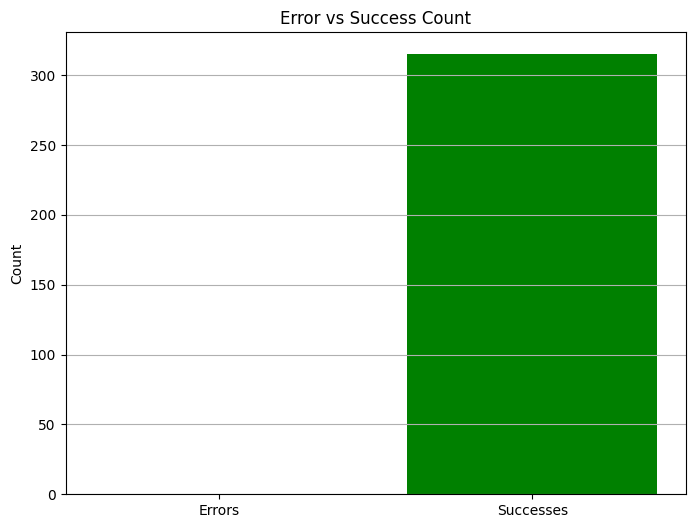

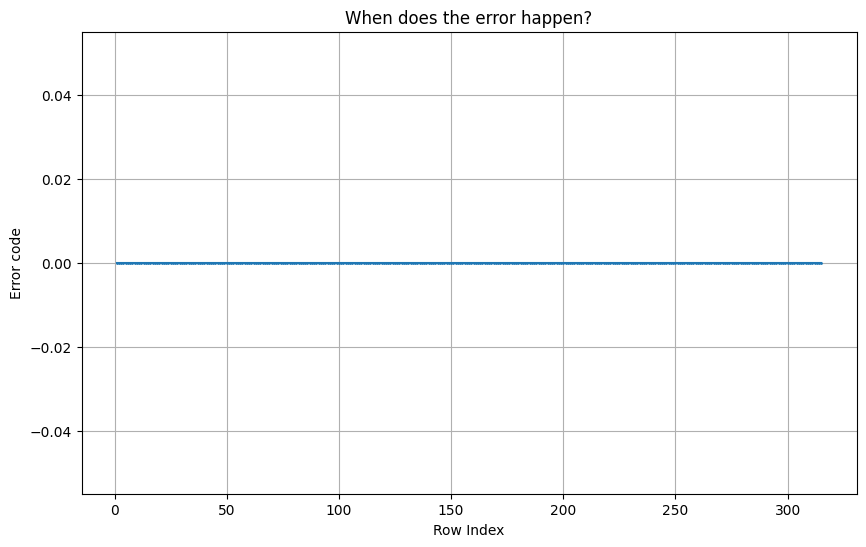

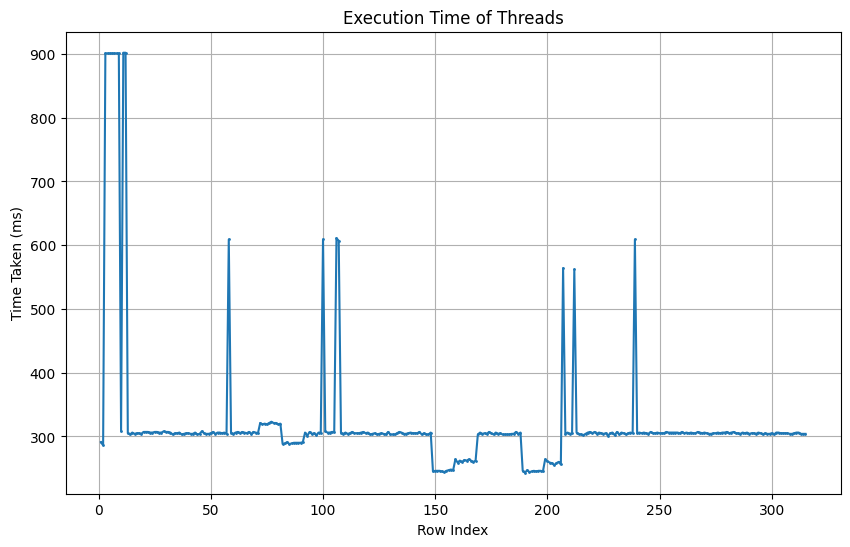

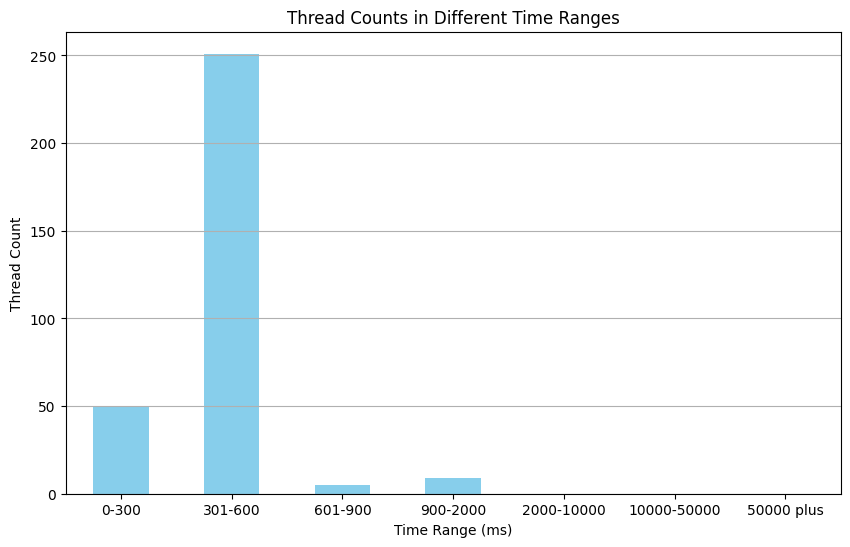

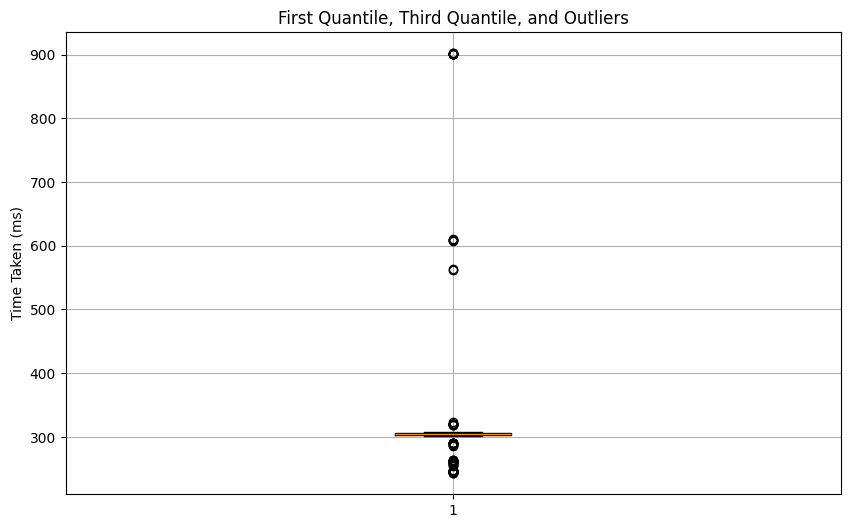

In [4]:
analyze_csv("output-test.csv", 10)

In [8]:
df = analyze_csv_noplot("output-test.csv", 10)
print(df)

                                     Value
Actual num of thr started        10.000000
Threads successfully requested   10.000000
Threads success rate            100.000000
Error Rate                        0.000000
Throughput                       30.793496
Mean                            322.158730
Median                          305.000000
Standard Deviation              110.208113


In [9]:
df_concat_250thr = concat_bra_local("multi-region-to-swi/output-from-bra/output-250thr-2min-timeout.csv", 
                                    "multi-region-to-swi/output-from-local/output-250thr-2min-timeout.csv",
                                    "multi-region-to-swi/processing/concat-bra-eu-250thr.csv")

df_bra = pd.read_csv("multi-region-to-swi/output-from-bra/output-250thr-2min-timeout.csv")
print(len(df_bra))
df_local = pd.read_csv("multi-region-to-swi/output-from-local/output-250thr-2min-timeout.csv")
print(len(df_local))
print(df_concat_250thr)

/tmp/ipykernel_224303/2345047743.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


149414
1351561
         threadId                       duration region
0              16                            363    bra
1              16                            197    bra
2             129                            671    bra
3              96                            671    bra
4             120                            671    bra
...           ...                            ...    ...
1500970       217                             20     eu
1500971       166                             18     eu
1500972       256                             31     eu
1500973        -1  2024-04-05T12:22:53.868005481     eu
1500974        -2  2024-04-05T12:24:53.958541973     eu

[1500975 rows x 3 columns]


/tmp/ipykernel_224303/3894434975.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_local = pd.read_csv("multi-region-to-swi/output-from-local/output-250thr-2min-timeout.csv")


In [15]:
result_bra = analyze_csv_noplot("multi-region-to-swi/output-from-bra/output-250thr-2min-timeout.csv", 250)
result_local = analyze_csv_noplot("multi-region-to-swi/output-from-local/output-250thr-2min-timeout.csv", 250)
result_concat = analyze_csv_noplot("multi-region-to-swi/processing/concat-bra-eu-250thr.csv", 500, with_regions=True)

print(result_bra)
print(result_local)
print(result_concat)

/tmp/ipykernel_224303/3831800277.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)
/tmp/ipykernel_224303/3831800277.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


                                      Value
Actual num of thr started        250.000000
Threads successfully requested   250.000000
Threads success rate (%)         100.000000
Error Rate (%)                     0.000000
Throughput                      1241.810444
Mean                             199.720752
Median                           198.000000
Standard Deviation                25.779814
                                       Value
Actual num of thr started         250.000000
Threads successfully requested    250.000000
Threads success rate (%)          100.000000
Error Rate (%)                      0.000000
Throughput                      11254.500521
Mean                               19.815593
Median                             18.000000
Standard Deviation                 13.052983
                                       Value
Actual num of thr started         500.000000
Threads successfully requested    500.000000
Threads success rate (%)          100.000000
Error Rate (%)     

## Local to AUS

### Everything

In [43]:
# Directory containing CSV files
folder_path = "output-aus"

# Regular expression pattern to match "{numThreads}thr" in the file name
pattern_thr = r"(\d+)thr"
results_all = []
# Iterate over files in the directory
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        # Use regular expression to extract expected number of threads from file name
        if file_name == "output-2000thr-2min.csv":
            continue
        match = re.search(pattern_thr, file_name)
        if match and "2min" in file_name:
            expected_number_of_threads = int(match.group(1))
            name = "aus-"+str(expected_number_of_threads)+"thr"     
            # Construct full file path
            file_path = os.path.join(folder_path, file_name)
            
            # Call analyze_csv function with file path and expected number of threads
            result = analyze_csv_noplot(file_path, expected_number_of_threads, name)
            results_all.append(result.T)

/tmp/ipykernel_224303/417539148.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)
/tmp/ipykernel_224303/417539148.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


In [44]:
print(results_all)

[              Name Actual num of thr started Threads successfully requested  \
Value  aus-1750thr                      1750                           1379   

      Threads success rate (%) Error Rate (%) Throughput        Mean Median  \
Value                     78.8      28.693228  69.725121  506.325477  253.0   

      Standard Deviation Error Count Success Count  
Value         530.048648        3500          8698  ,               Name Actual num of thr started Threads successfully requested  \
Value  aus-1000thr                      1000                           1000   

      Threads success rate (%) Error Rate (%)   Throughput        Mean Median  \
Value                    100.0            0.0  3811.419048  257.881144  246.0   

      Standard Deviation  
Value          179.99436  ,              Name Actual num of thr started Threads successfully requested  \
Value  aus-500thr                       500                            500   

      Threads success rate (%) Error Rat

In [45]:
concatenated_df = pd.concat(results_all)

# Reset index to concatenate the DataFrames properly
concatenated_df.reset_index(drop=True, inplace=True)
print(concatenated_df)

concatenated_df.to_csv("output-aus/result-all.csv", index=False)

          Name Actual num of thr started Threads successfully requested  \
0  aus-1750thr                      1750                           1379   
1  aus-1000thr                      1000                           1000   
2   aus-500thr                       500                            500   
3  aus-1500thr                      1500                           1471   
4  aus-2000thr                      2000                           1133   
5   aus-100thr                       100                            100   
6  aus-1200thr                      1200                           1200   

  Threads success rate (%) Error Rate (%)   Throughput         Mean  Median  \
0                     78.8      28.693228    69.725121   506.325477   253.0   
1                    100.0            0.0  3811.419048   257.881144   246.0   
2                    100.0            0.0  1974.273347   252.139684   245.0   
3                98.066667       0.180551   295.409787  4893.426119  1646.0   
4   

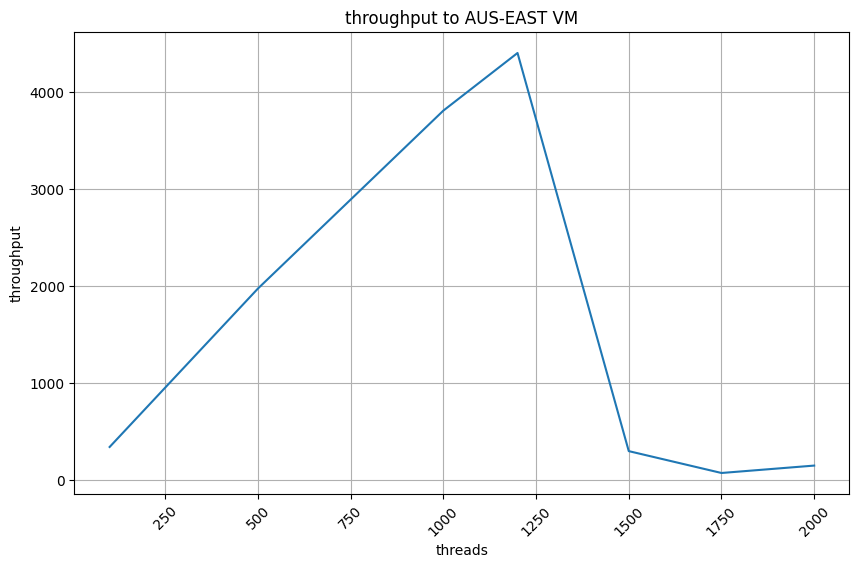

In [54]:
plot_final_results(pd.read_csv("output-aus/result-all.csv"), "throughput", "output-aus/tp-plot.png")

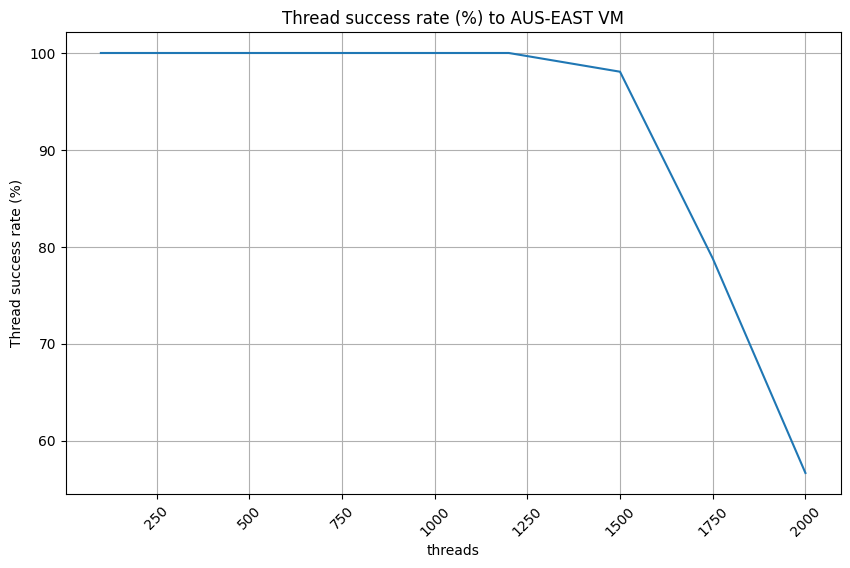

In [57]:
plot_final_results(pd.read_csv("output-aus/result-all.csv"), "Thread success rate (%)", "output-aus/thr-success-rate-plot.png")

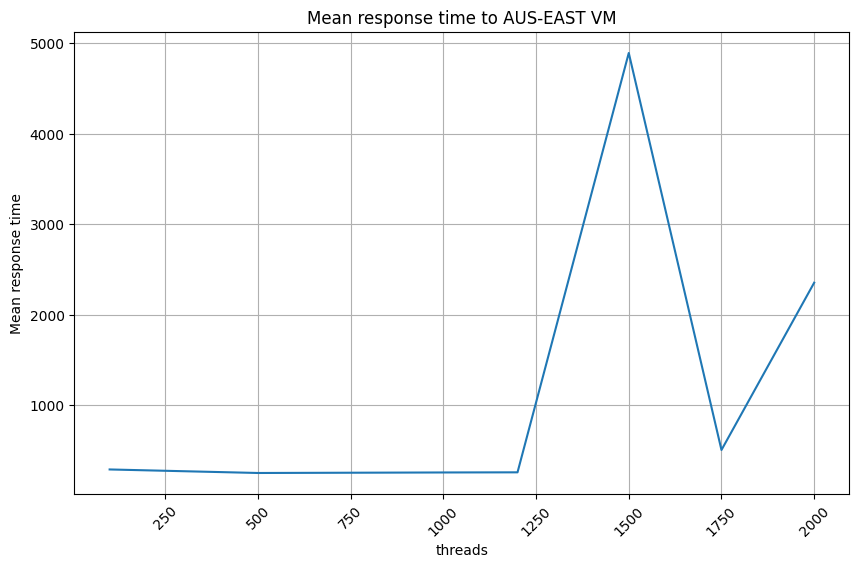

In [59]:
plot_final_results(pd.read_csv("output-aus/result-all.csv"), "Mean response time", "output-aus/mean-plot.png")

/tmp/ipykernel_224303/1474914297.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={'Mean': 'Mean Response Time (ms)'}, inplace=True)
/tmp/ipykernel_224303/1474914297.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={'Throughput': 'Throughput (invocation/s)'}, inplace=True)


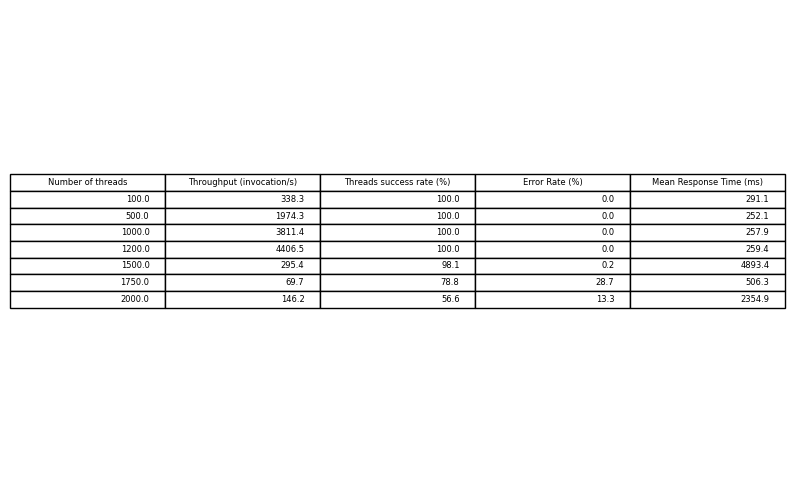

In [66]:
df = pd.read_csv('output-aus/result-all.csv')
df['Number of threads'] = df['Name'].apply(lambda x: int(re.search(r'\d+', x).group()))

# Sort the DataFrame by the numeric part of the "Name" column
df_sorted = df.sort_values(by='Number of threads')
# Select the desired columns
df_selected = df_sorted[['Number of threads', 'Throughput', 'Threads success rate (%)', 'Error Rate (%)', 'Mean']]

# Rename the 'Mean' column to 'Mean Response Time'
df_selected.rename(columns={'Mean': 'Mean Response Time (ms)'}, inplace=True)
df_selected.rename(columns={'Throughput': 'Throughput (invocation/s)'}, inplace=True)
df_selected = df_selected.round({'Throughput (invocation/s)': 1, 'Threads success rate (%)': 1, 'Error Rate (%)':1,  'Mean Response Time (ms)': 1})

# Plot the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_selected.values, colLabels=df_selected.columns, loc='center')

# Save the plot as an image
plt.savefig('output-aus/main-table.png', bbox_inches='tight')
plt.show()

### 2000 Threads, 2 minutes (in code, but actual time is about 5 mins), no timeout

Error in extracting start time and end time
index 0 is out of bounds for axis 0 with size 0
Actual num of thr started: 1958
Threads successfully requested: 1267
Threads success rate: 63.35%
Error Rate: 20.29%
Stats of the successful fetches:
Mean: 3231.023174544786
Median: 246.0
Standard Deviation: 21496.19504811389


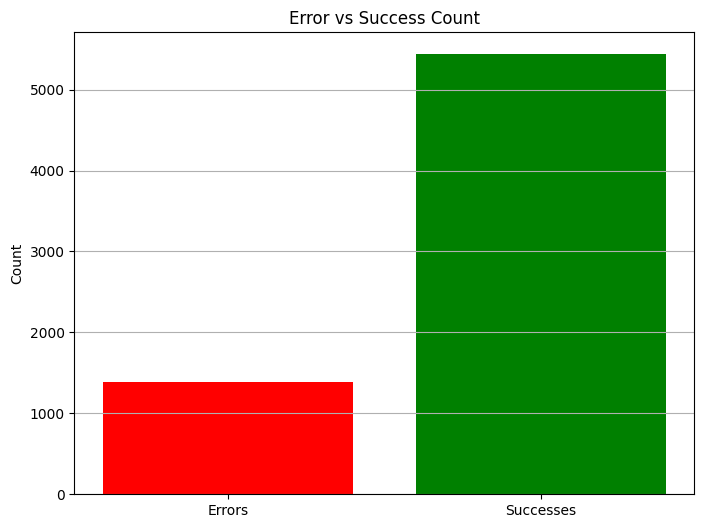

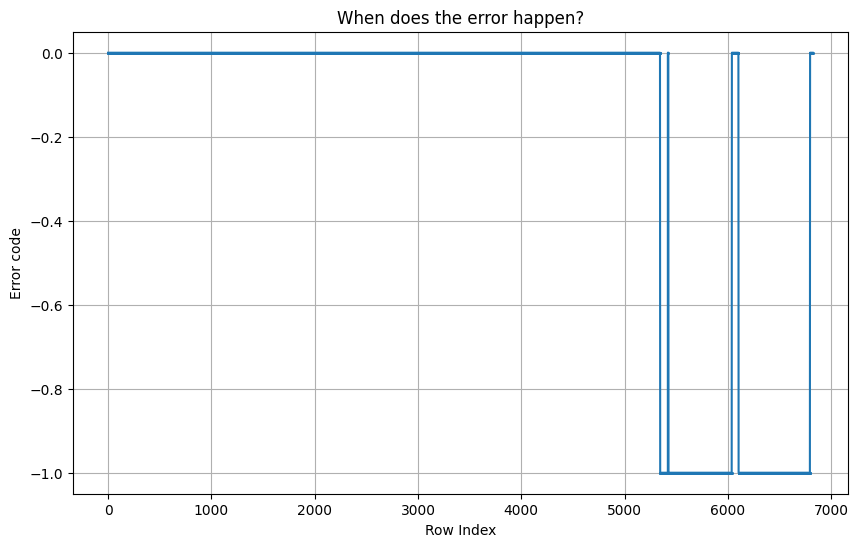

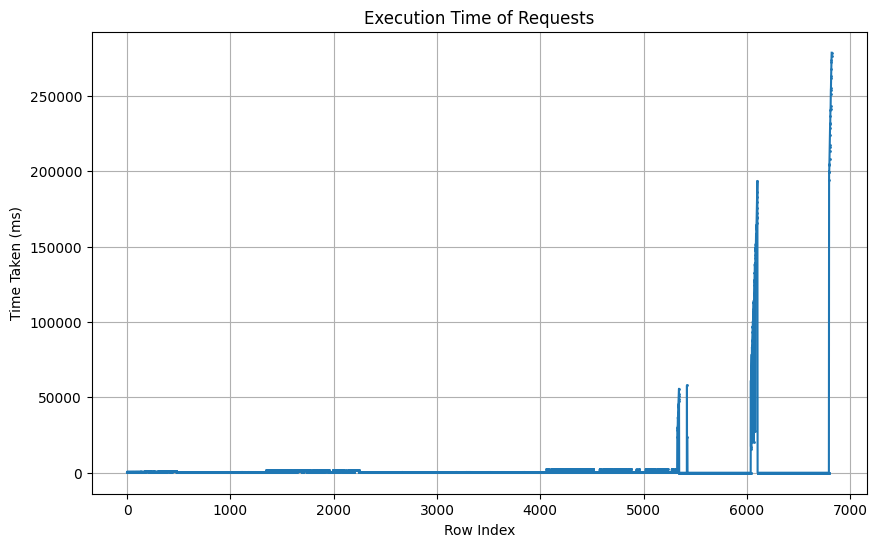

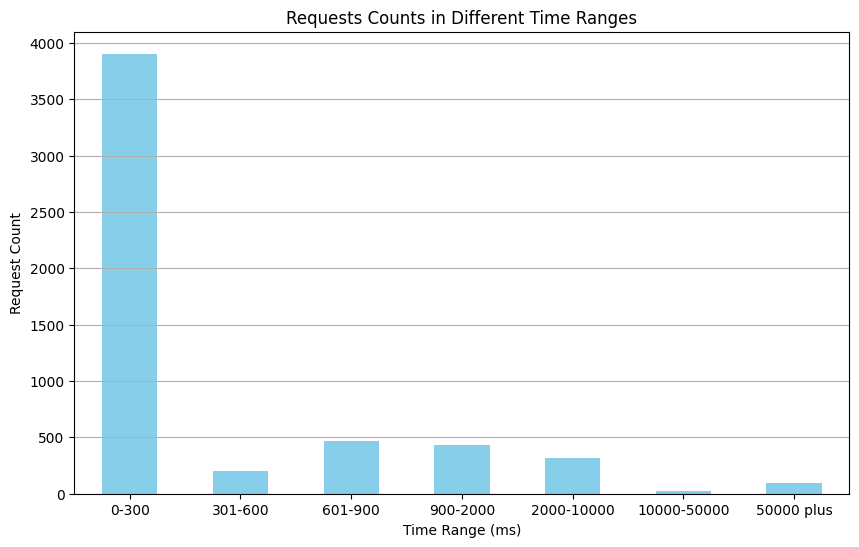

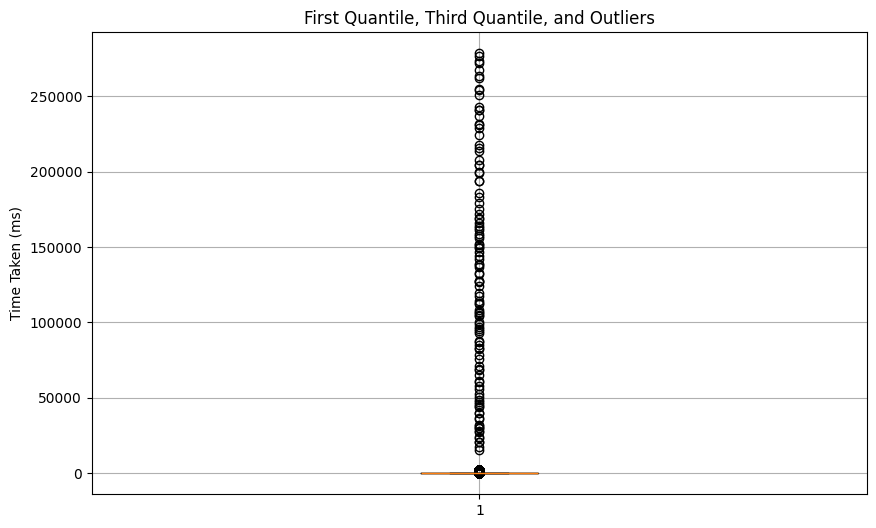

In [5]:
analyze_csv("output-aus-2cols/output-2000thr-2min.csv", 2000)

### 550 Thread, 2 min, timeout

/tmp/ipykernel_139301/2483294046.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Actual num of thr started: 550
Throughput: 1728.2182996777206
Threads successfully requested: 539
Threads success rate: 98.00%
Error Rate: 0.04%
Stats of the successful fetches:
Mean: 292.4568560618807
Median: 261.0
Standard Deviation: 800.3760752275756


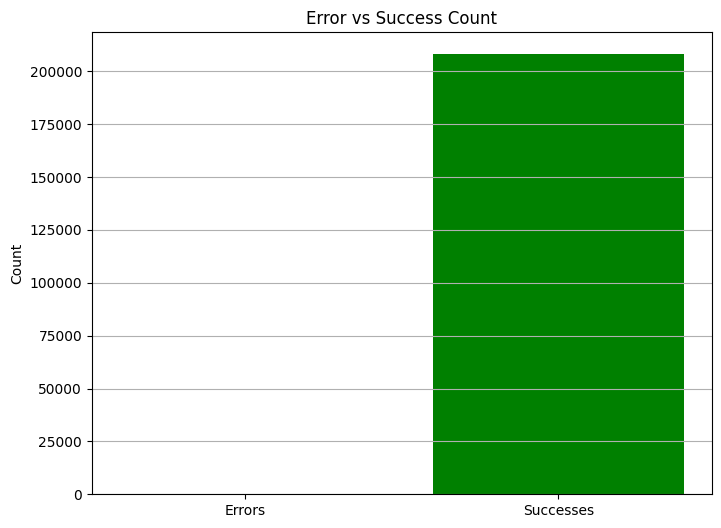

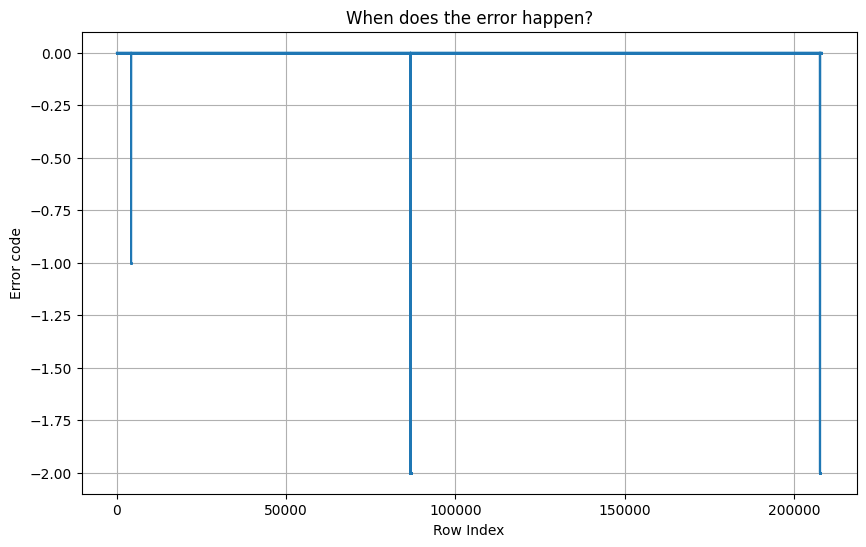

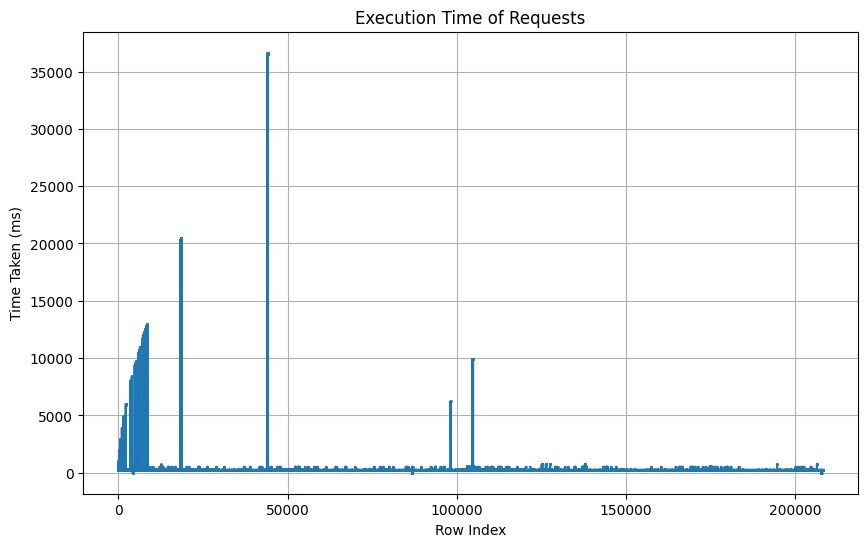

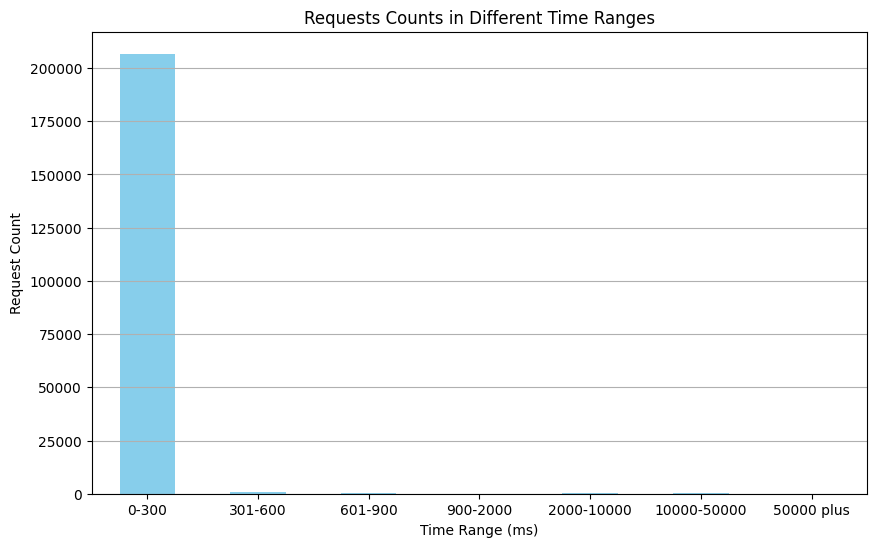

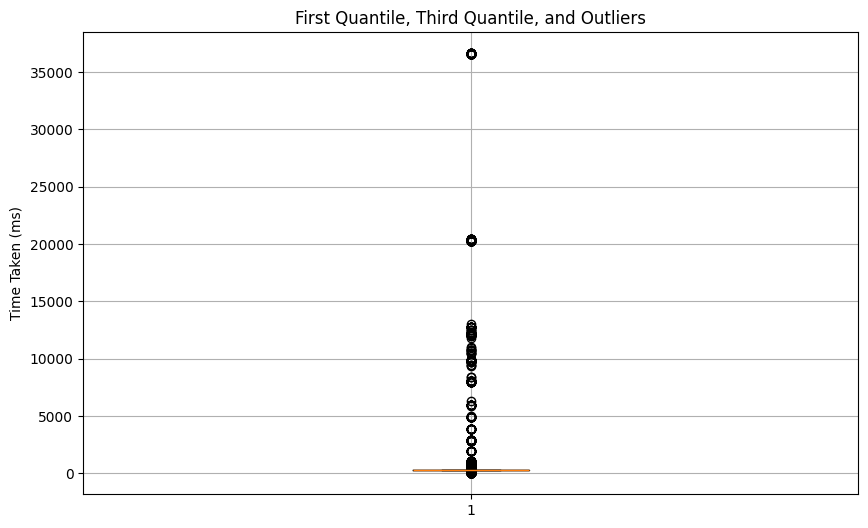

In [4]:
analyze_csv("output-aus-4cols/output-550thr-2min-timeout.csv", 550)

### 1000 thread, 2 minutes, timeout

/tmp/ipykernel_154904/2483294046.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Actual num of thr started: 1000
Throughput: 3811.4190475232376
Threads successfully requested: 1000
Threads success rate: 100.00%
Error Rate: 0.00%
Stats of the successful fetches:
Mean: 257.88114402442585
Median: 246.0
Standard Deviation: 179.99436016221833


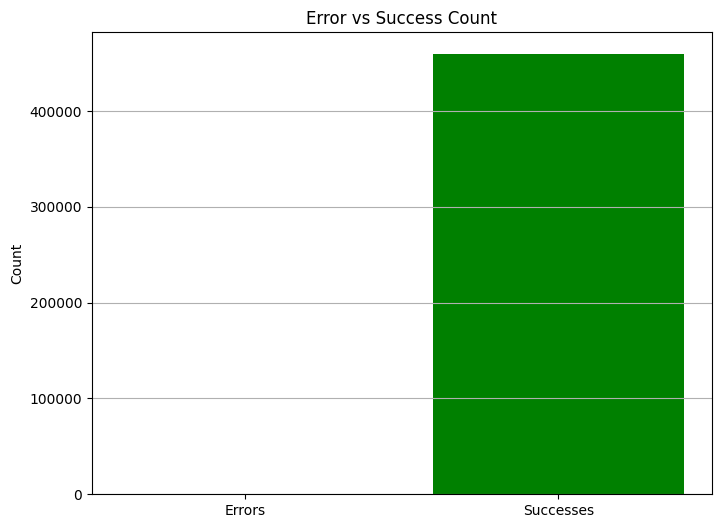

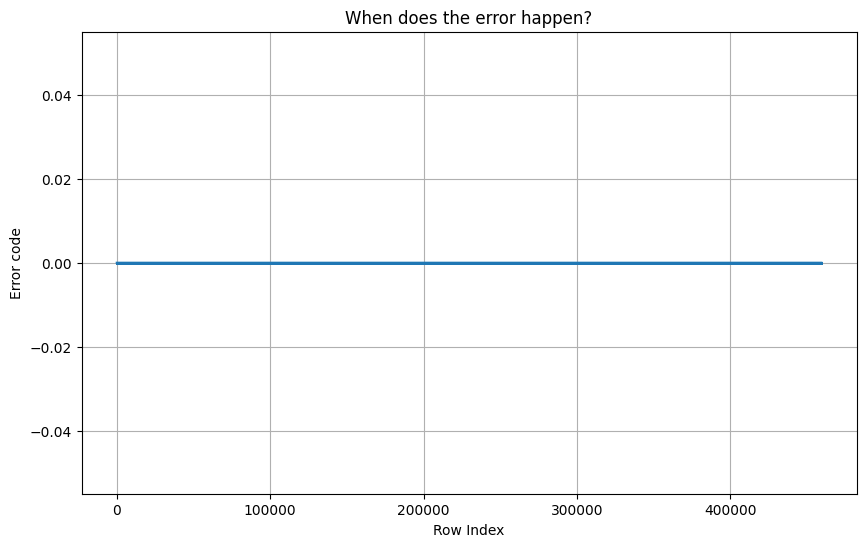

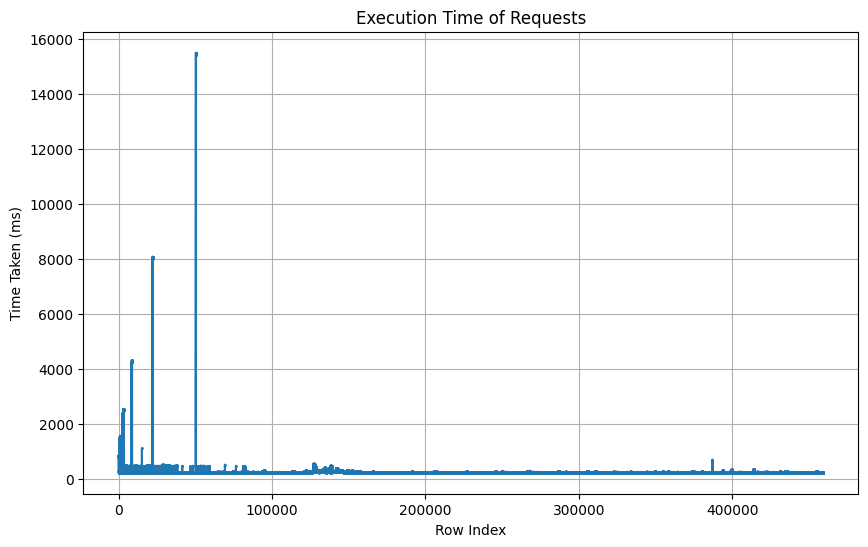

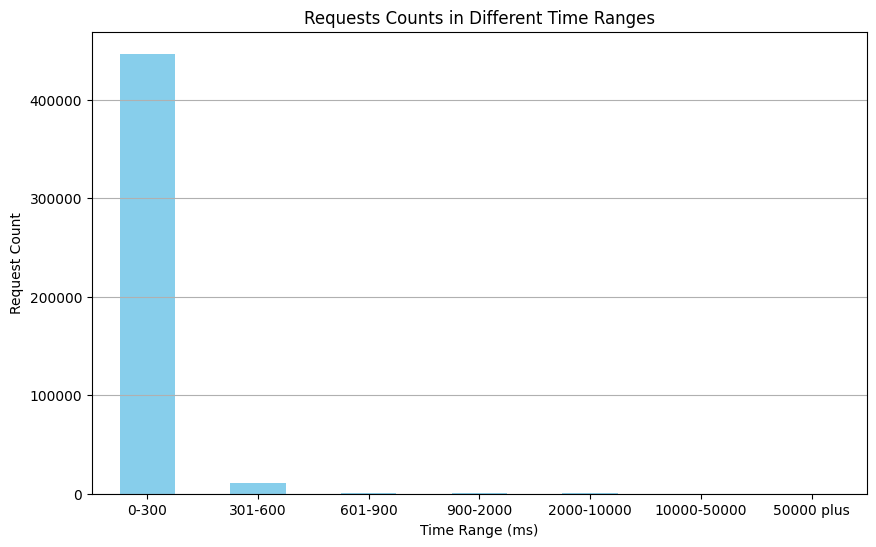

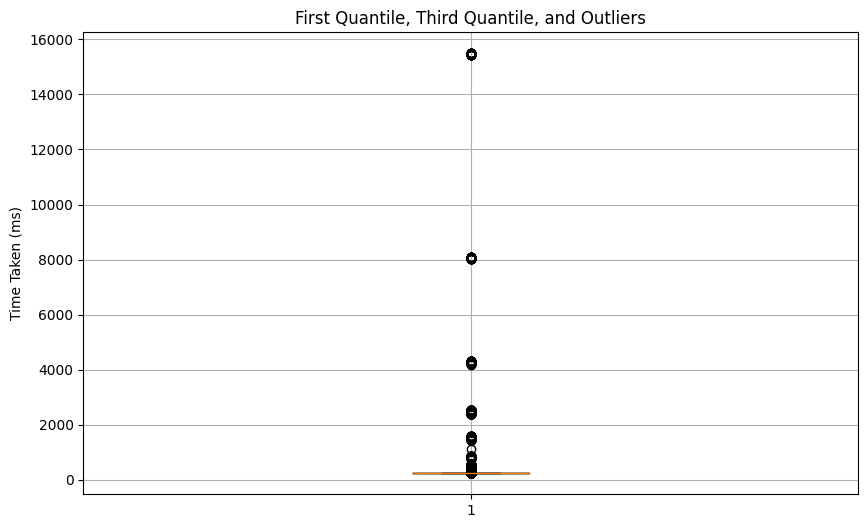

In [4]:
analyze_csv("output-aus/output-1000thr-2min.csv", 1000)

### 1200 threads, 2 min, timeout

/tmp/ipykernel_154904/2483294046.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Actual num of thr started: 1200
Throughput: 4406.451923720898
Threads successfully requested: 1200
Threads success rate: 100.00%
Error Rate: 0.00%
Stats of the successful fetches:
Mean: 259.38845023905264
Median: 248.0
Standard Deviation: 63.00218449190701


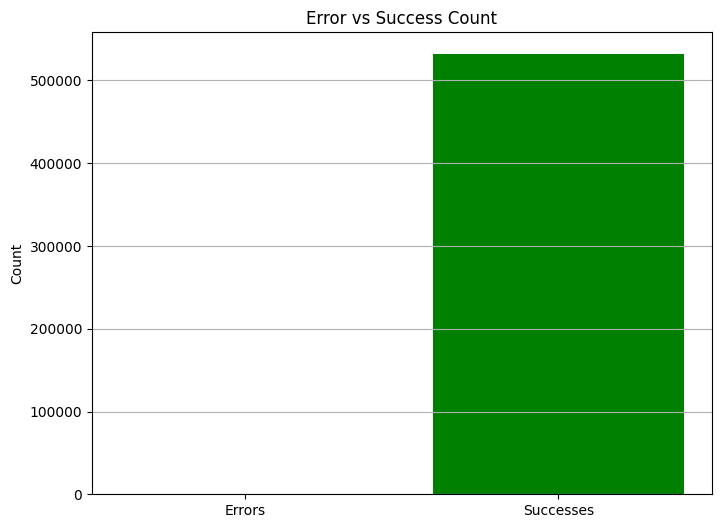

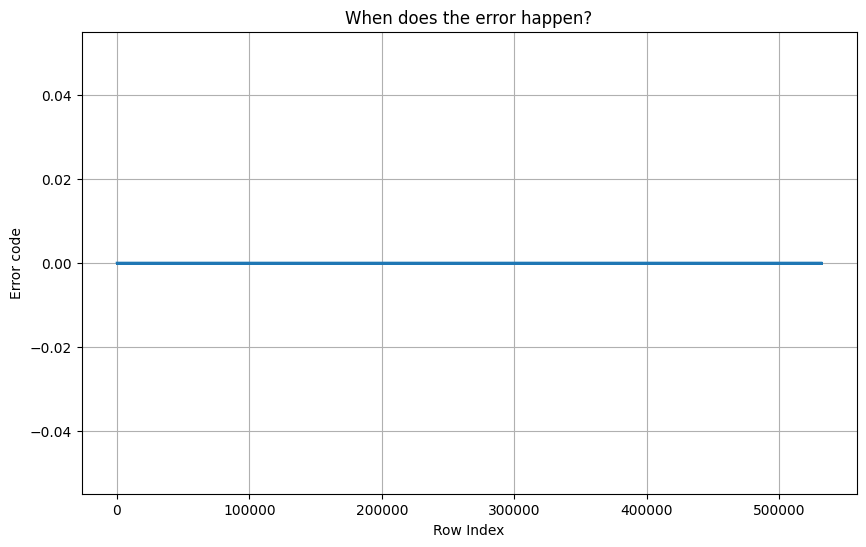

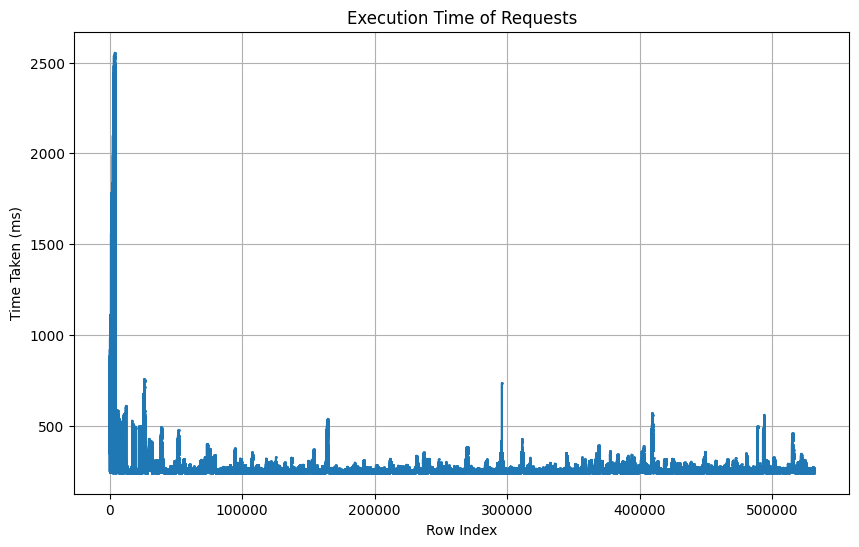

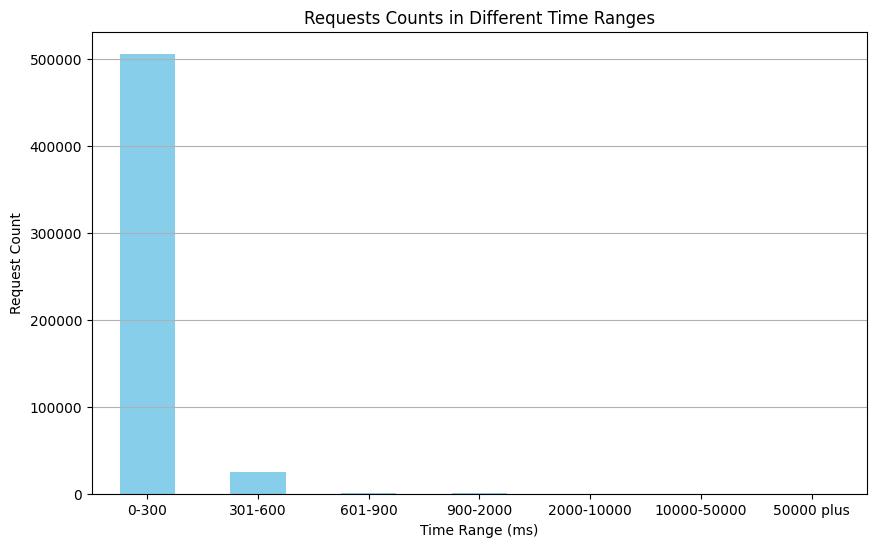

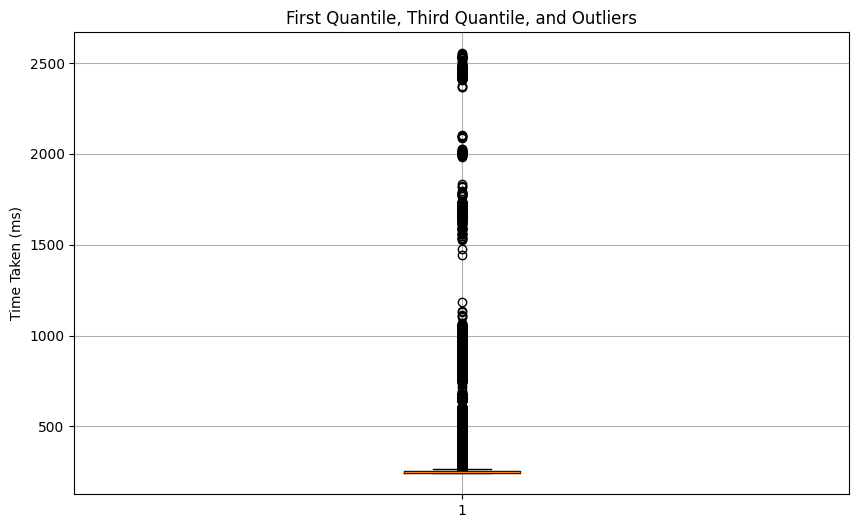

In [6]:
analyze_csv("output-aus/output-1200thr-2min-timeout.csv", 1200)

### 1500 thr, 2 min, timeout

Actual num of thr started: 1500
Throughput: 295.4097868318671
Threads successfully requested: 1471
Threads success rate: 98.07%
Error Rate: 0.18%
Stats of the successful fetches:
Mean: 4893.426118655388
Median: 1646.0
Standard Deviation: 7331.618457149834


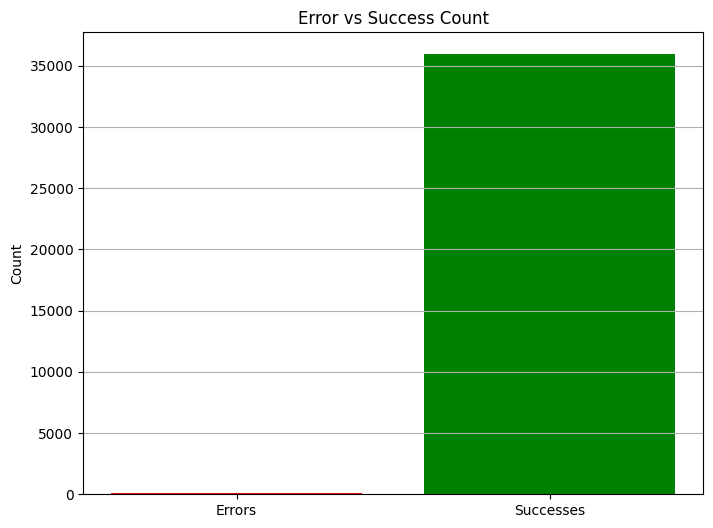

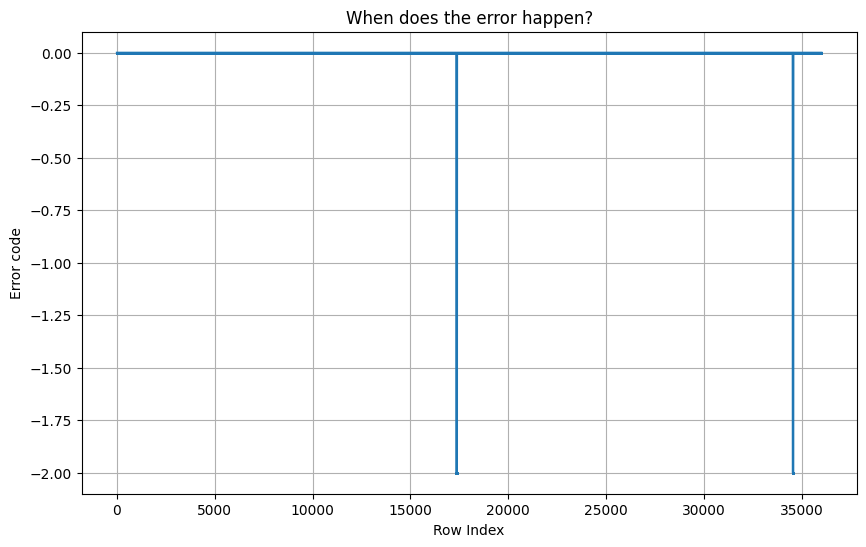

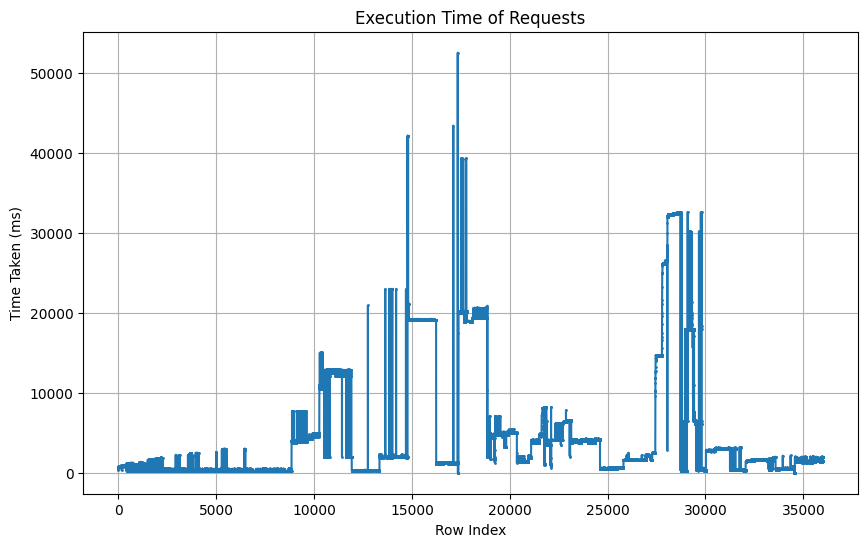

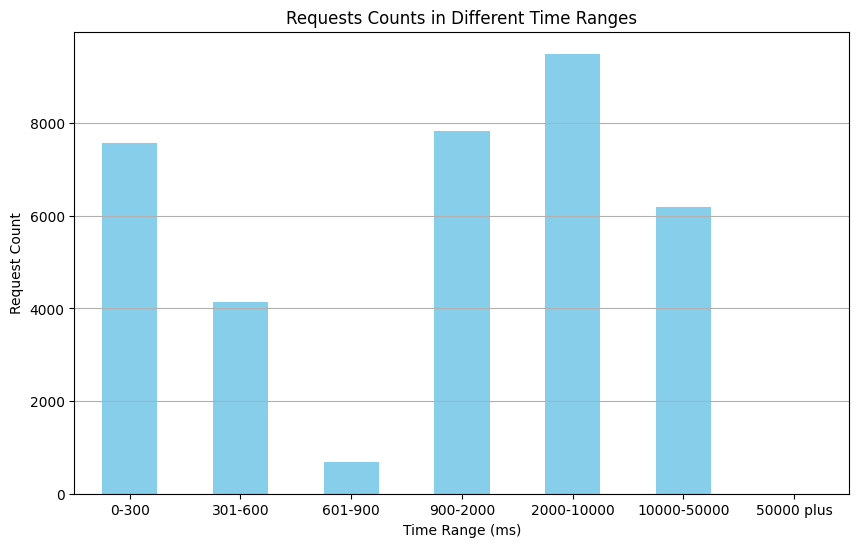

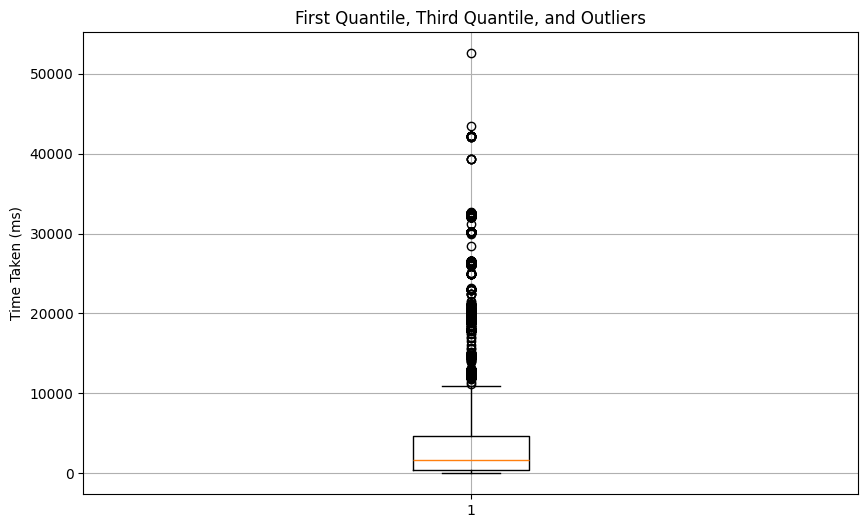

In [7]:
analyze_csv("output-aus/output-1500thr-2min-timeout.csv", 1500)

### 2000 threads, 2 minutes in code, 60 seconds timeout

Actual num of thr started: 2000
Throughput: 146.16433392384448
Threads successfully requested: 1133
Threads success rate: 56.65%
Error Rate: 13.33%
Stats of the successful fetches:
Mean: 2354.8594109526002
Median: 251.0
Standard Deviation: 9198.428846879582


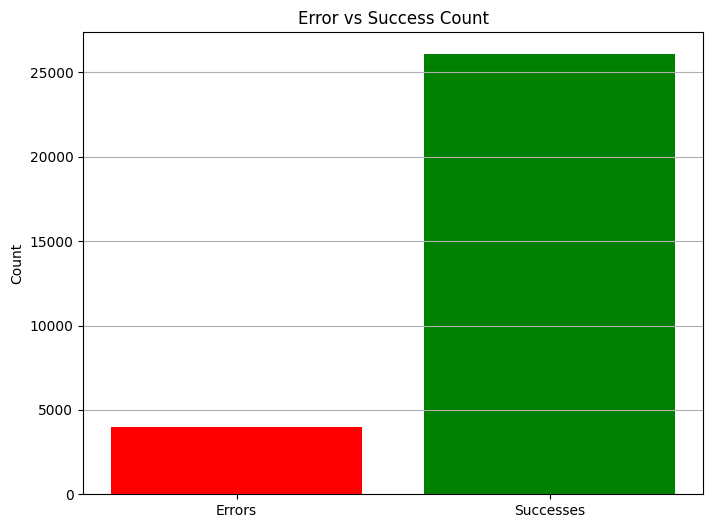

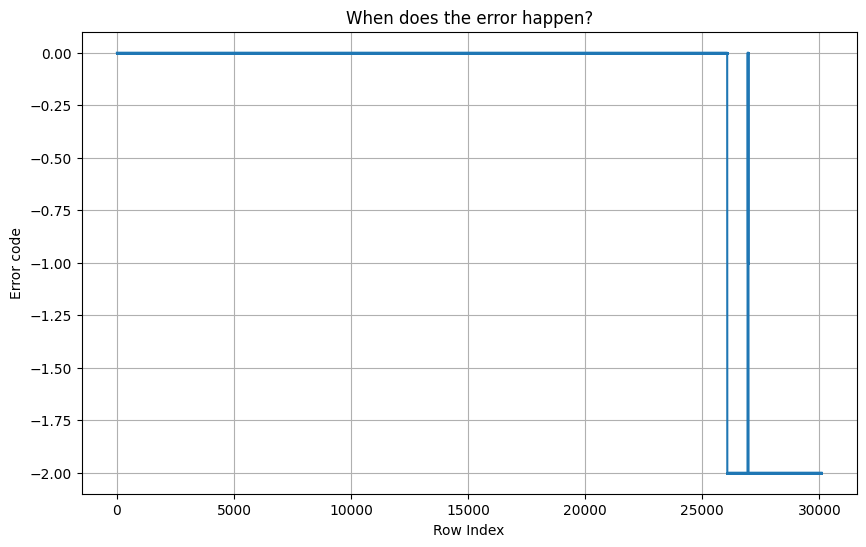

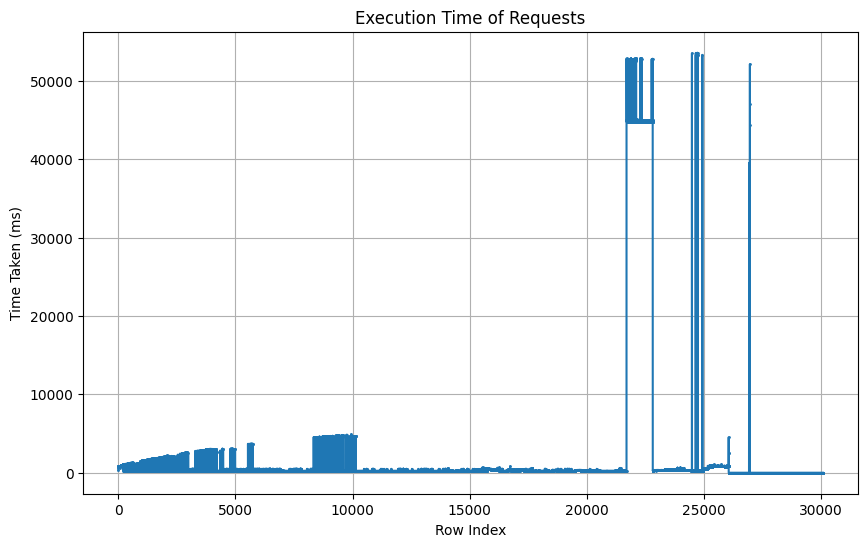

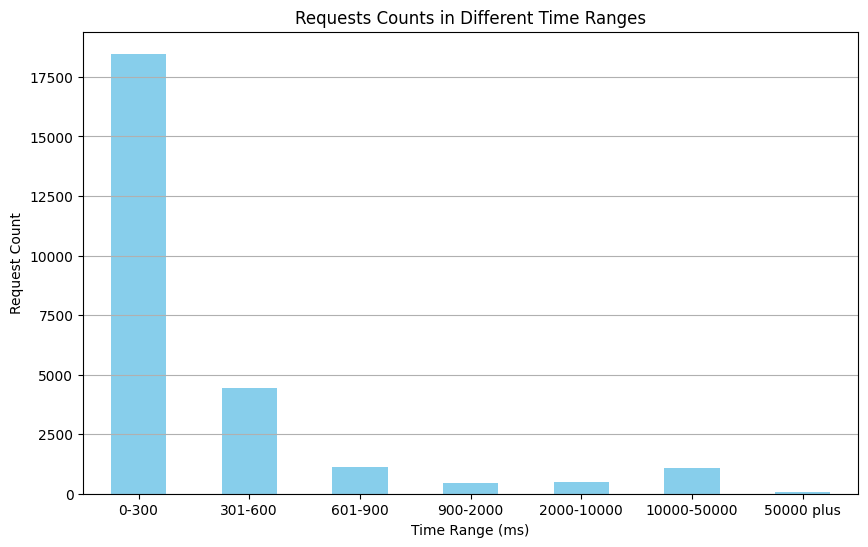

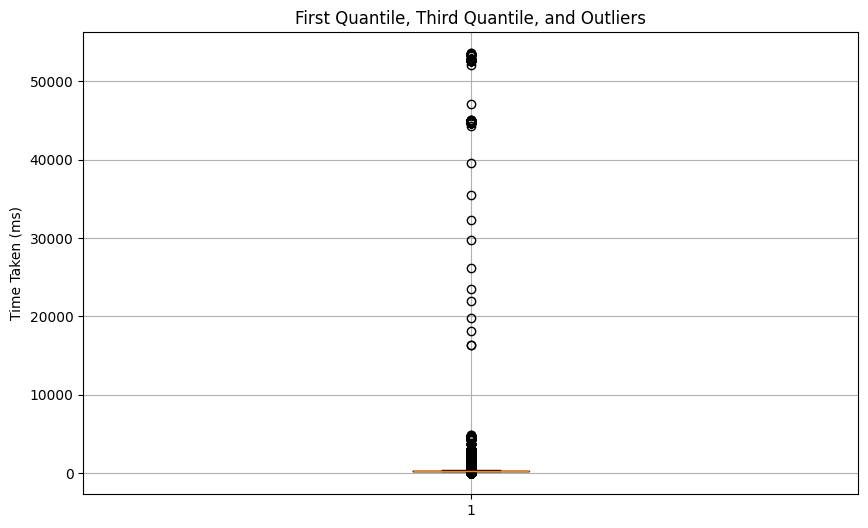

In [3]:
analyze_csv("output-aus-2cols/output-2000thr-2min-timeout.csv", 2000)

### 3000 thr, 2 min, timout

Actual num of thr started: 3000
Throughput: 1889.5025972664978
Threads successfully requested: 598
Threads success rate: 19.93%
Error Rate: 2.08%
Stats of the successful fetches:
Mean: 295.02848918223555
Median: 261.0
Standard Deviation: 836.0496431077772


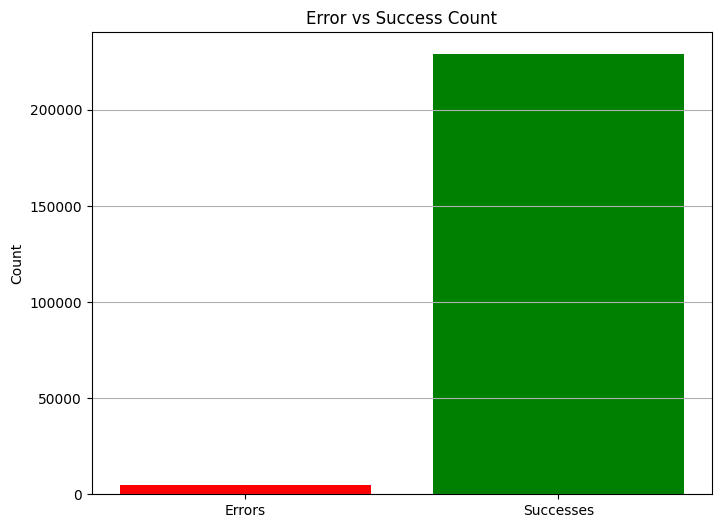

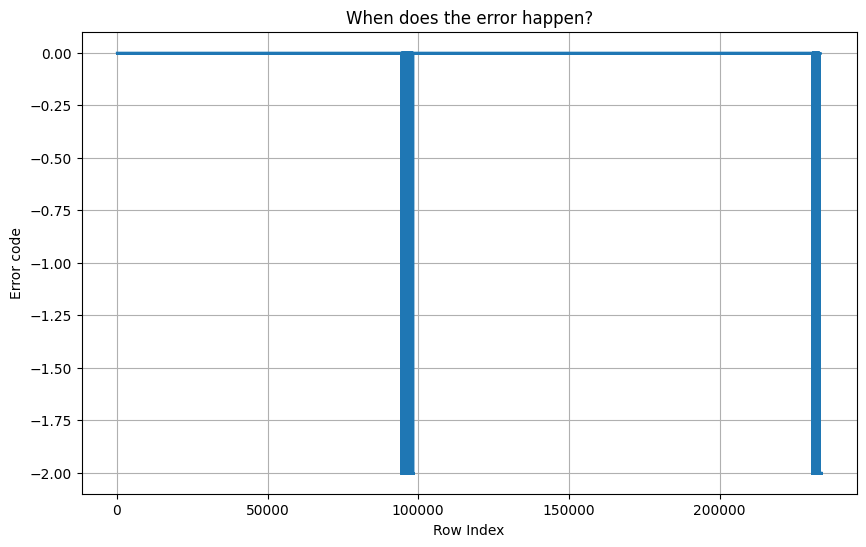

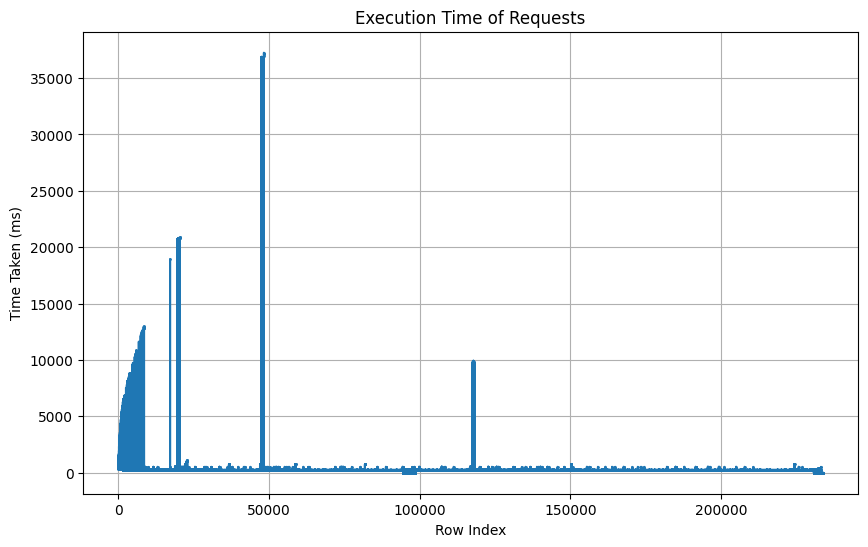

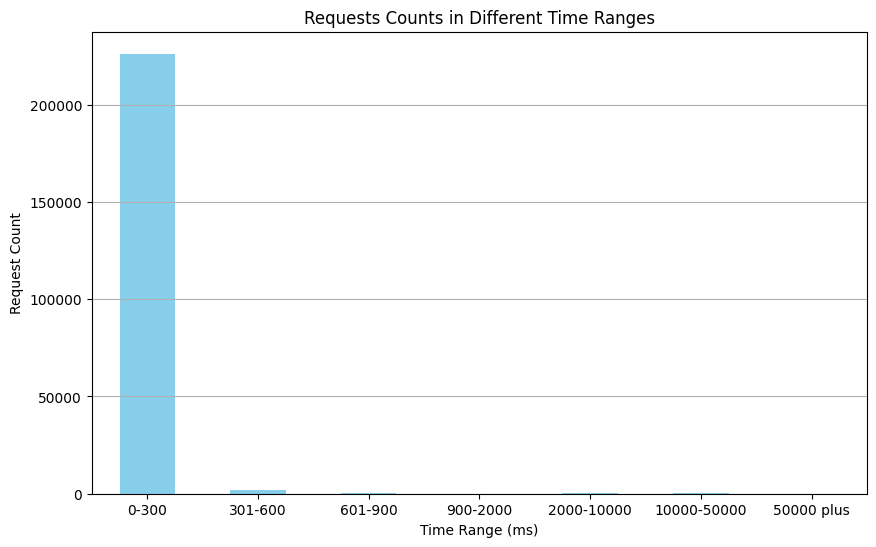

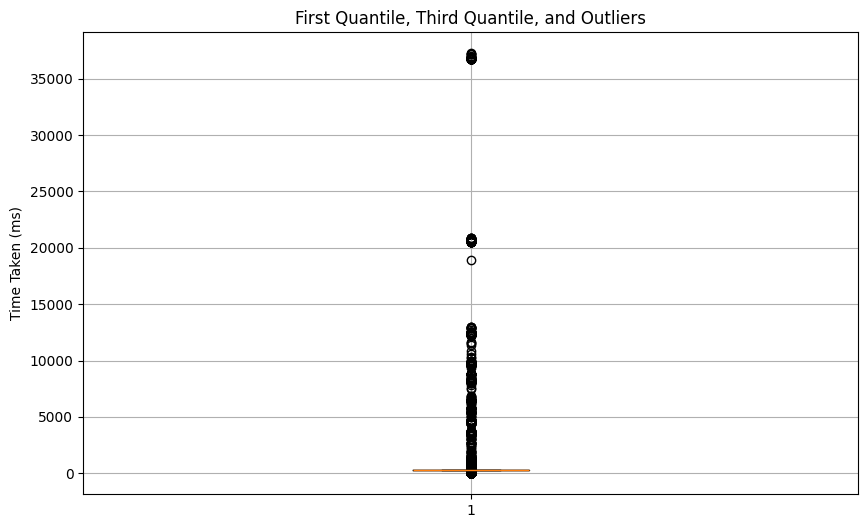

In [28]:
analyze_csv("output-aus-2cols/output-3000thr-2min-timeout.csv", 3000)

## Local to SWI

/tmp/ipykernel_201683/2483294046.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Actual num of thr started: 1750
Throughput: 7288.836097364321
Threads successfully requested: 1750
Threads success rate: 100.00%
Error Rate: 0.00%
Stats of the successful fetches:
Mean: 55.48754082448868
Median: 28.0
Standard Deviation: 114.15982498366753


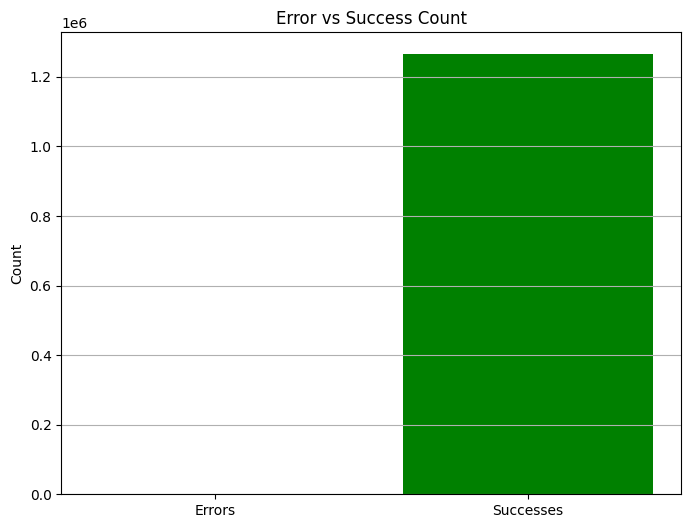

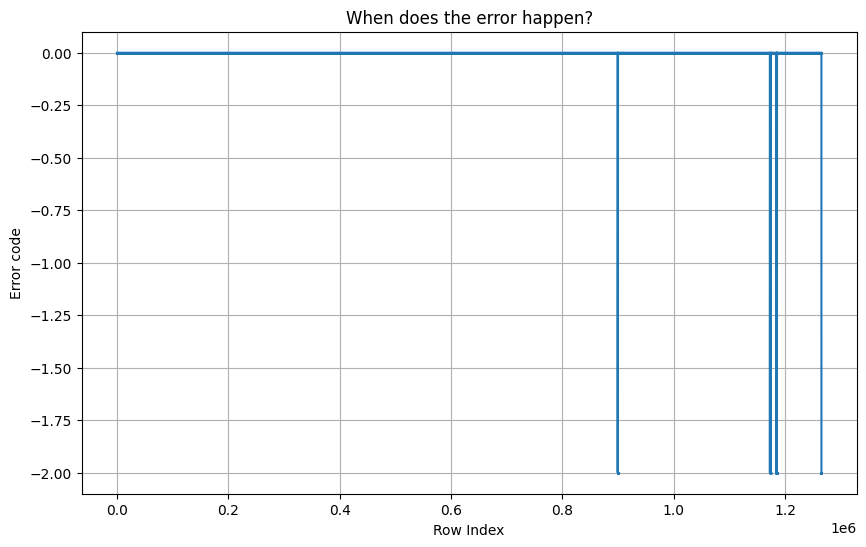

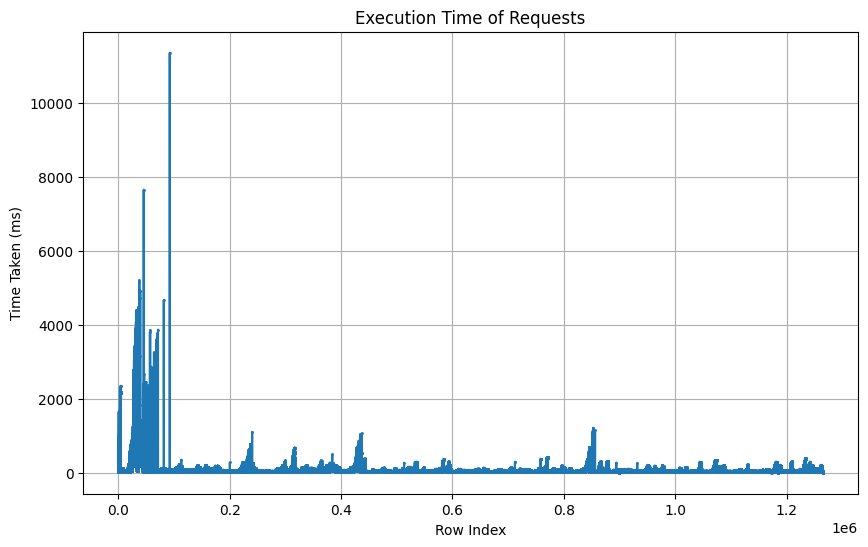

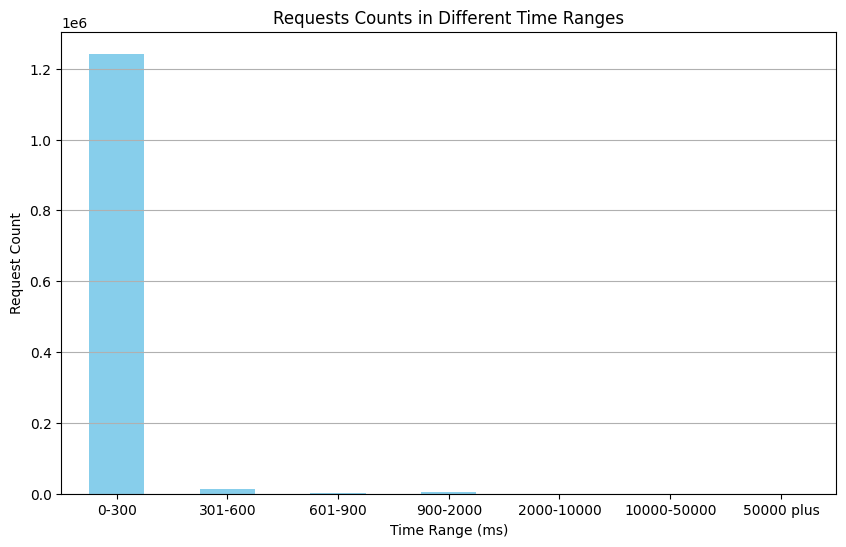

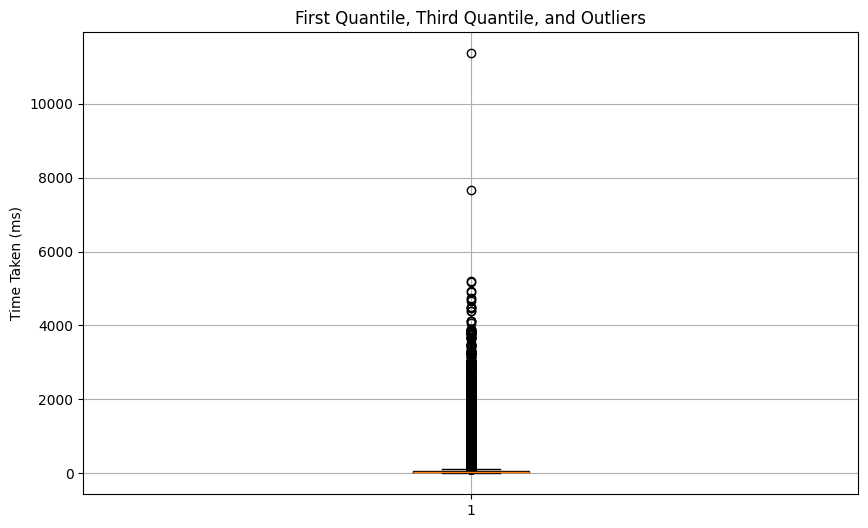

/tmp/ipykernel_201683/2483294046.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Actual num of thr started: 3000
Throughput: 8073.317054783194
Threads successfully requested: 3000
Threads success rate: 100.00%
Error Rate: 0.15%
Stats of the successful fetches:
Mean: 52.75577026894773
Median: 26.0
Standard Deviation: 435.37060879284485


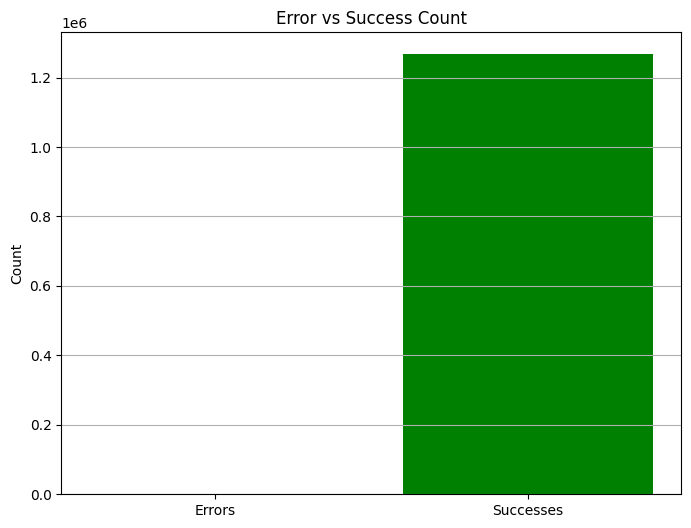

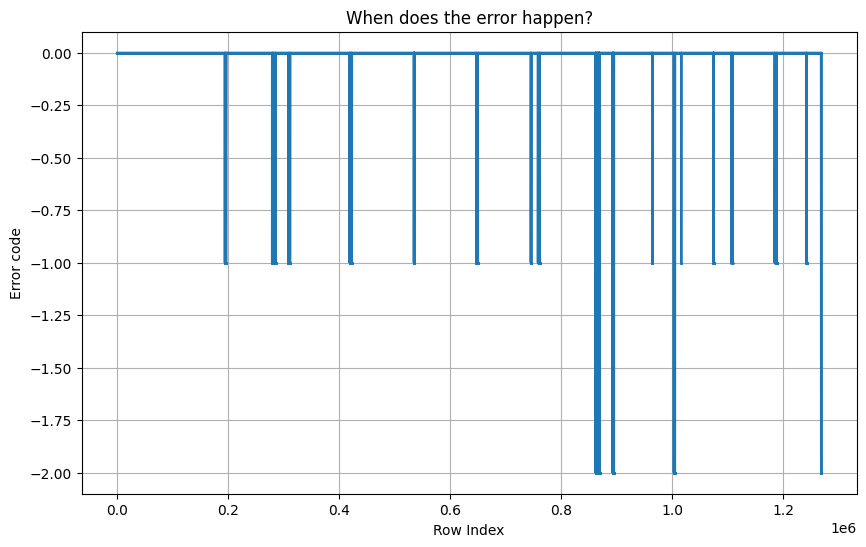

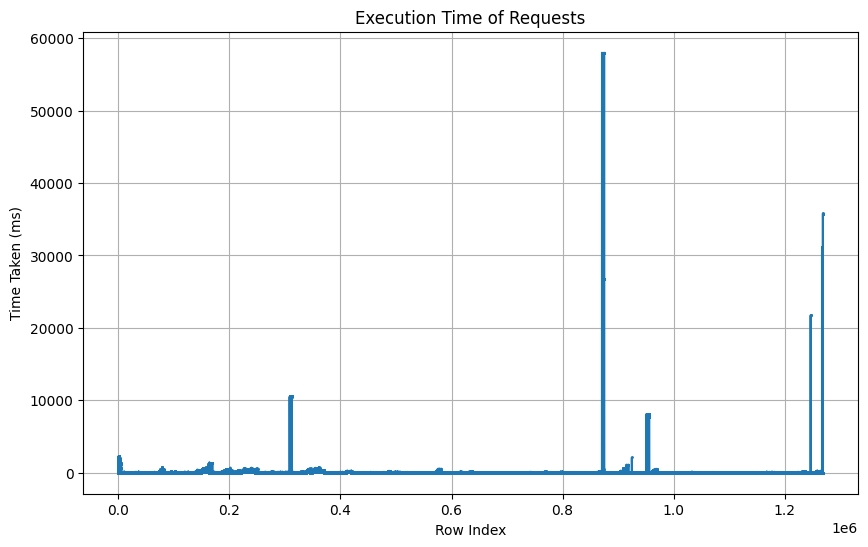

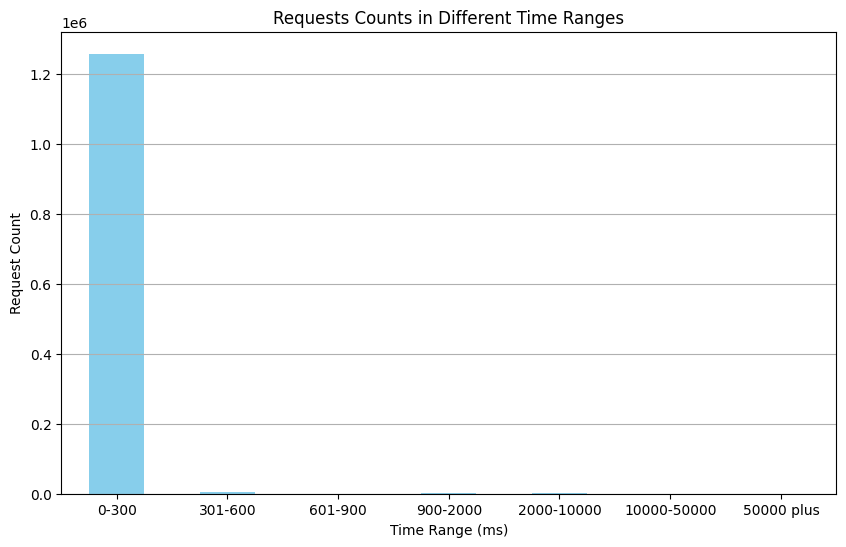

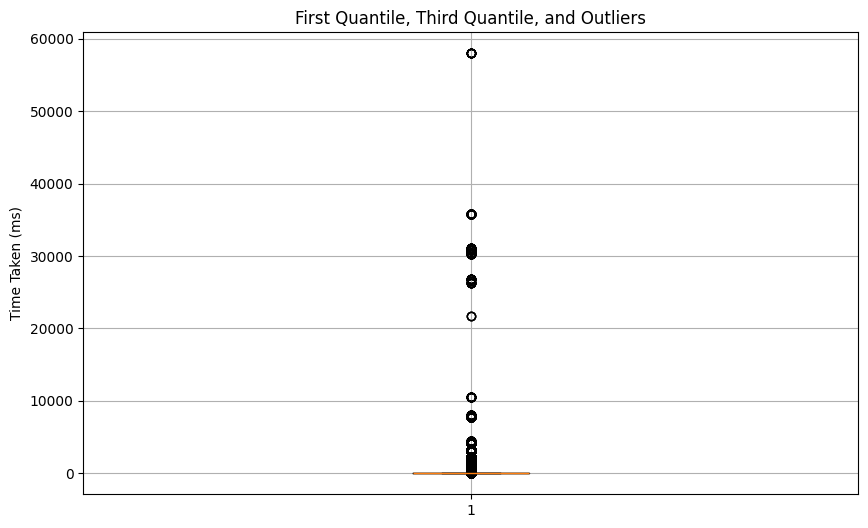

/tmp/ipykernel_201683/2483294046.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Actual num of thr started: 2771
Throughput: 6851.31975834241
Threads successfully requested: 2771
Threads success rate: 69.27%
Error Rate: 0.06%
Stats of the successful fetches:
Mean: 90.86146492968349
Median: 27.0
Standard Deviation: 447.36601159226535


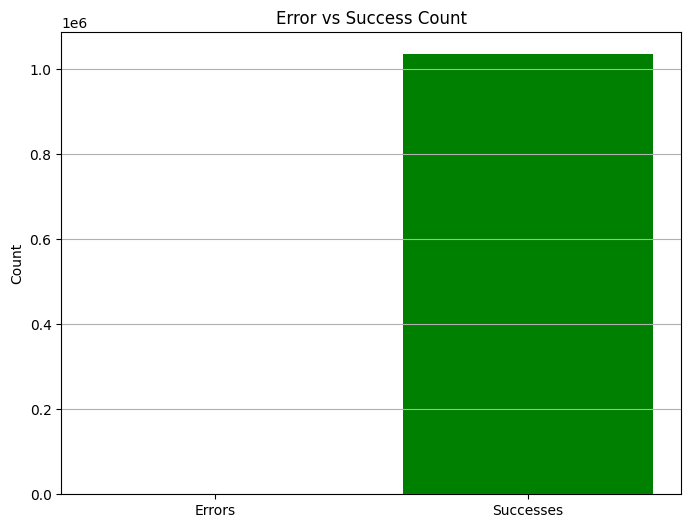

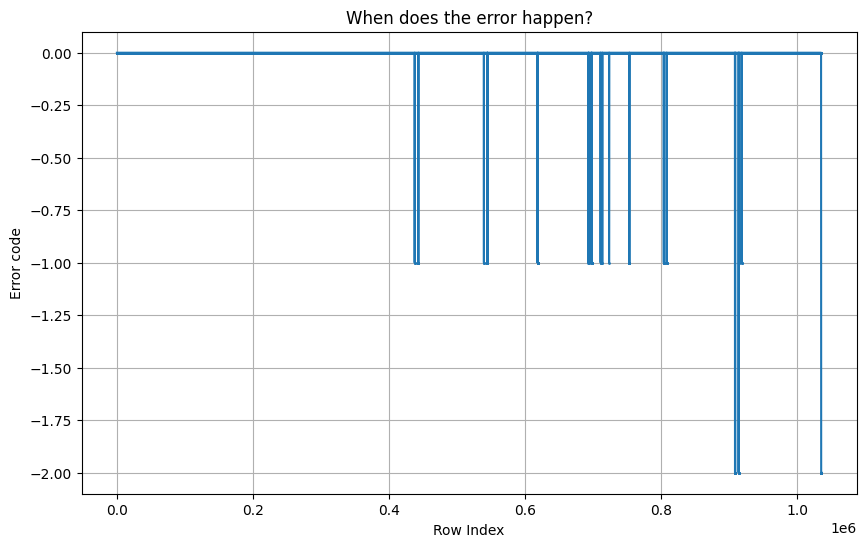

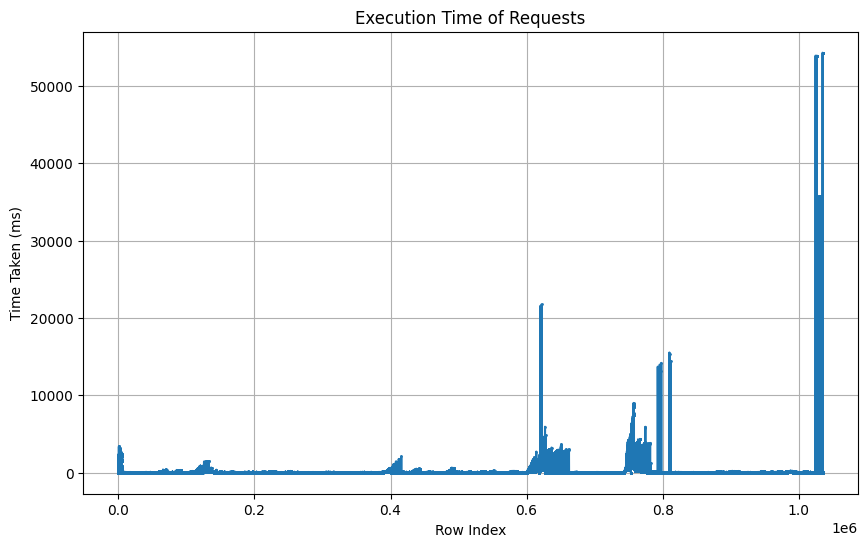

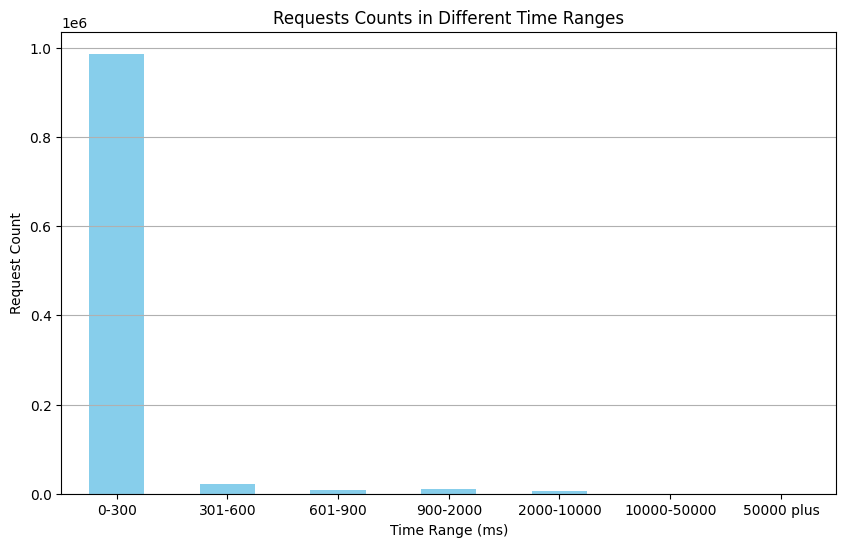

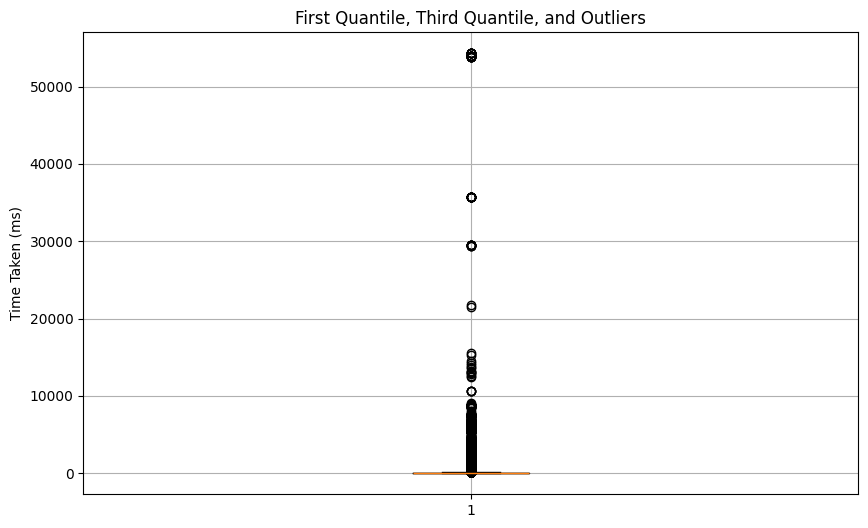

/tmp/ipykernel_201683/2483294046.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Actual num of thr started: 1000
Throughput: 7402.430671739201
Threads successfully requested: 1000
Threads success rate: 100.00%
Error Rate: 0.00%
Stats of the successful fetches:
Mean: 97.12264123418886
Median: 57.0
Standard Deviation: 157.35514984363886


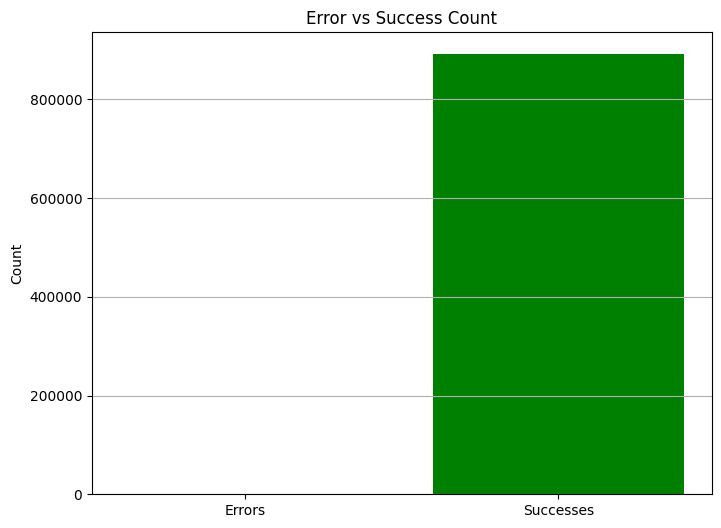

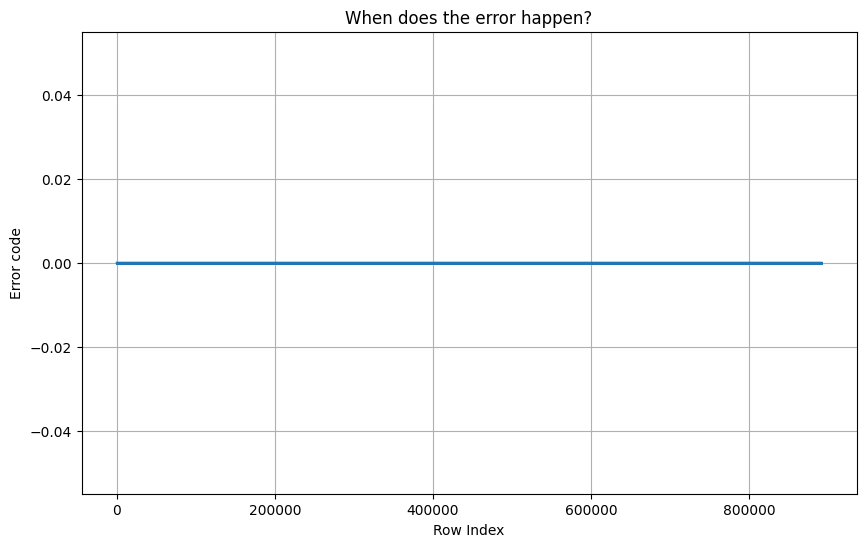

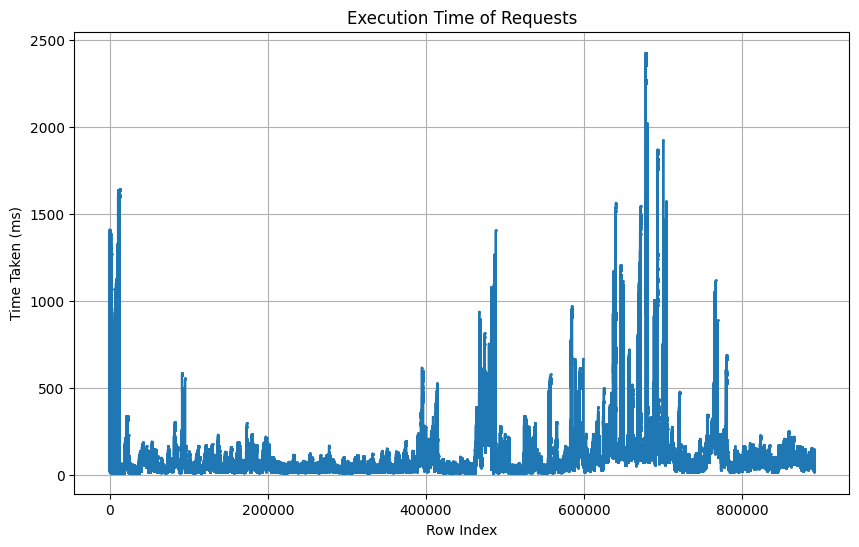

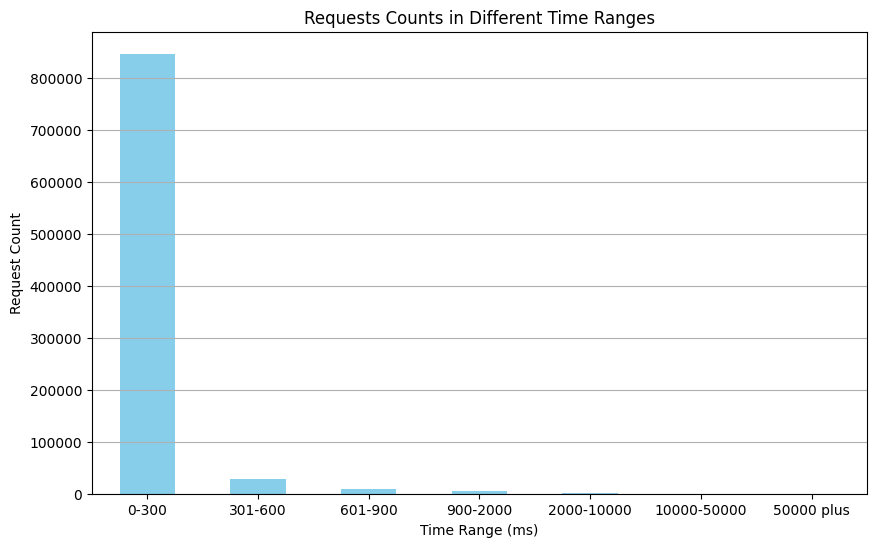

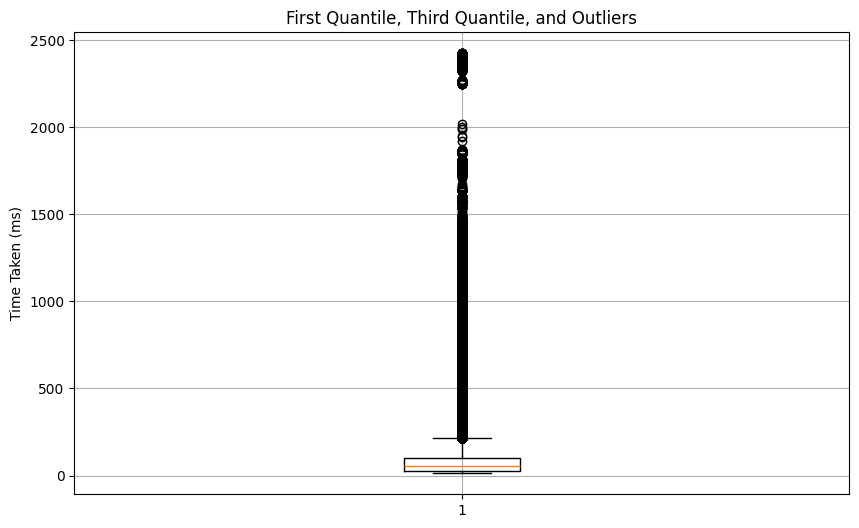

/tmp/ipykernel_201683/2483294046.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Actual num of thr started: 100
Throughput: 5080.451059891196
Threads successfully requested: 100
Threads success rate: 100.00%
Error Rate: 0.00%
Stats of the successful fetches:
Mean: 18.573109213388832
Median: 17.0
Standard Deviation: 9.829396942336698


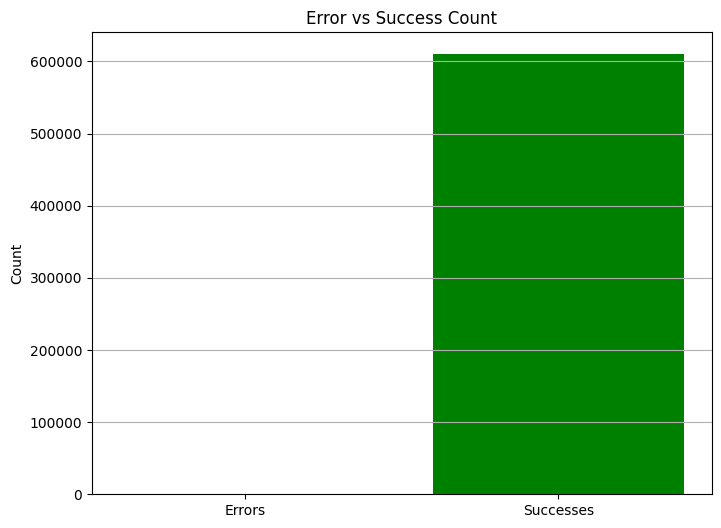

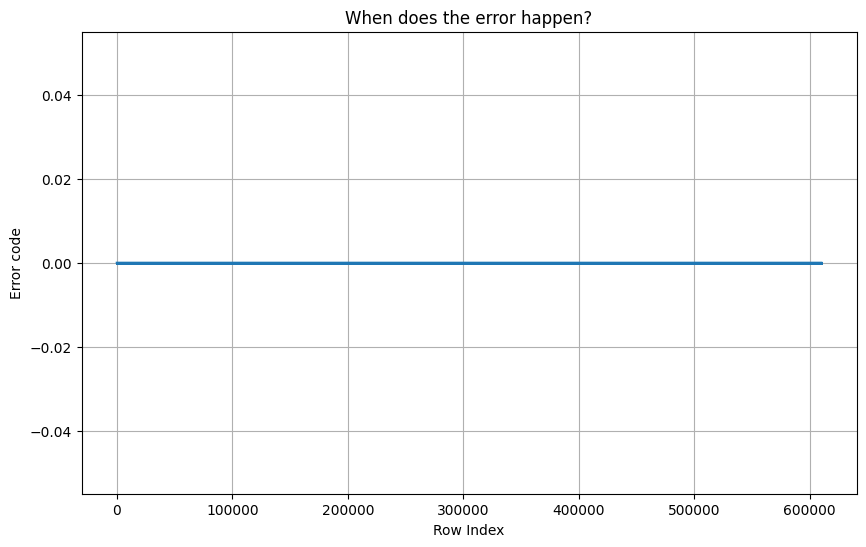

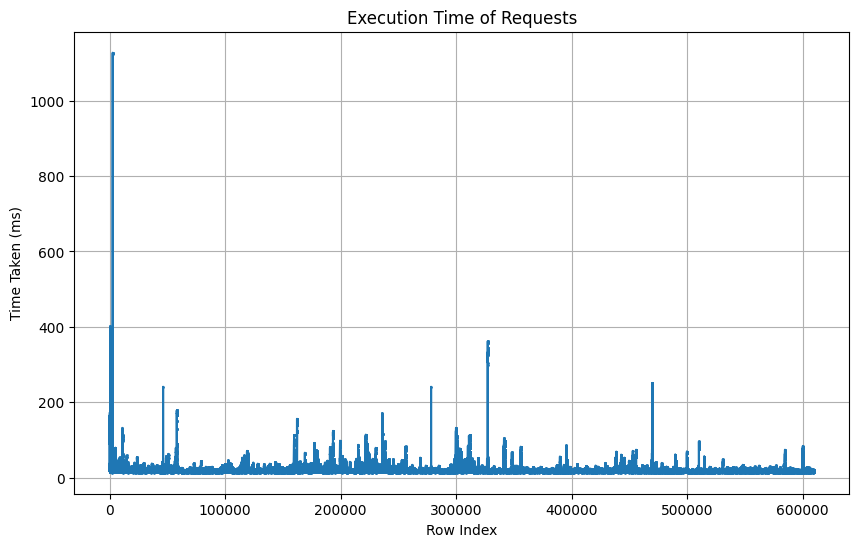

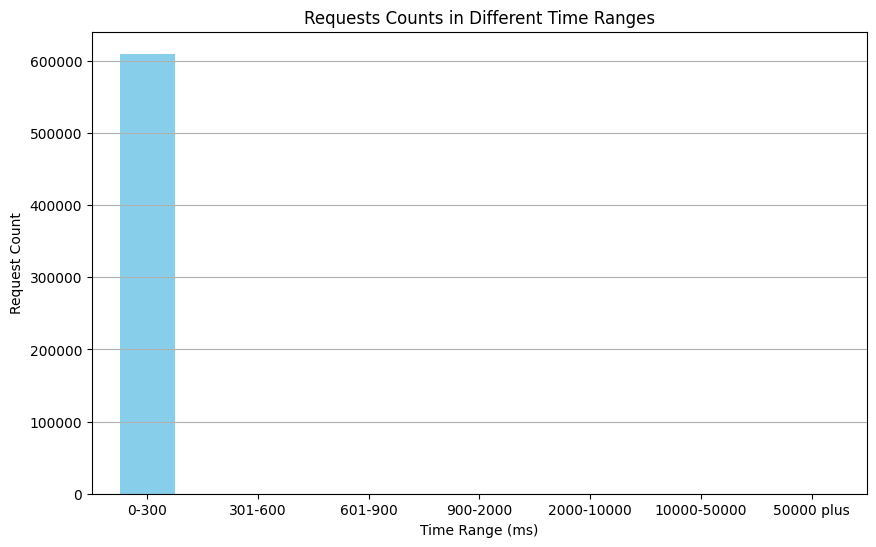

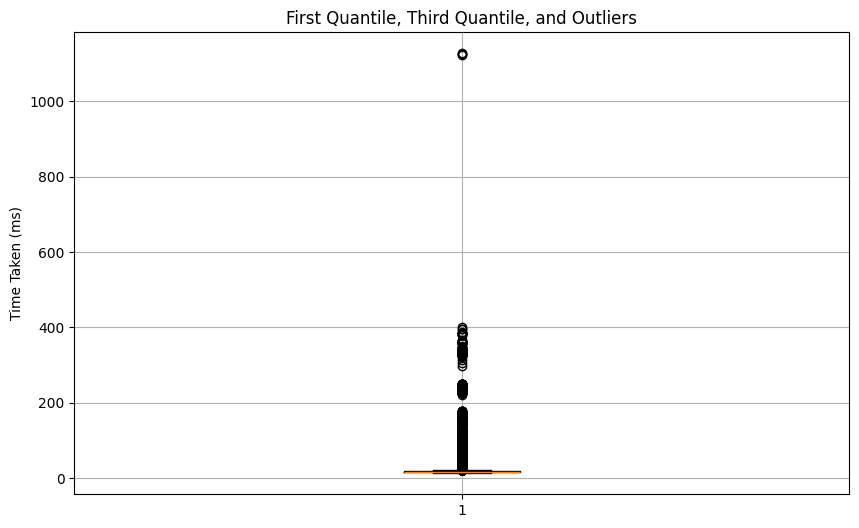

/tmp/ipykernel_201683/2483294046.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Actual num of thr started: 500
Throughput: 9937.546229905212
Threads successfully requested: 500
Threads success rate: 100.00%
Error Rate: 0.00%
Stats of the successful fetches:
Mean: 30.32559977495881
Median: 23.0
Standard Deviation: 28.592918077975778


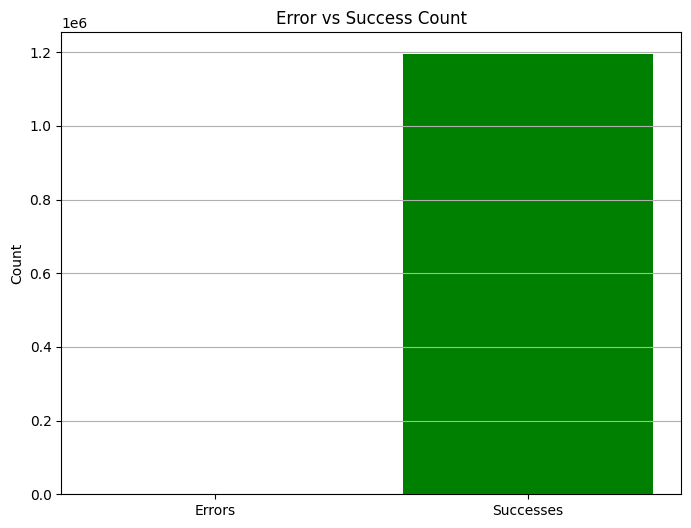

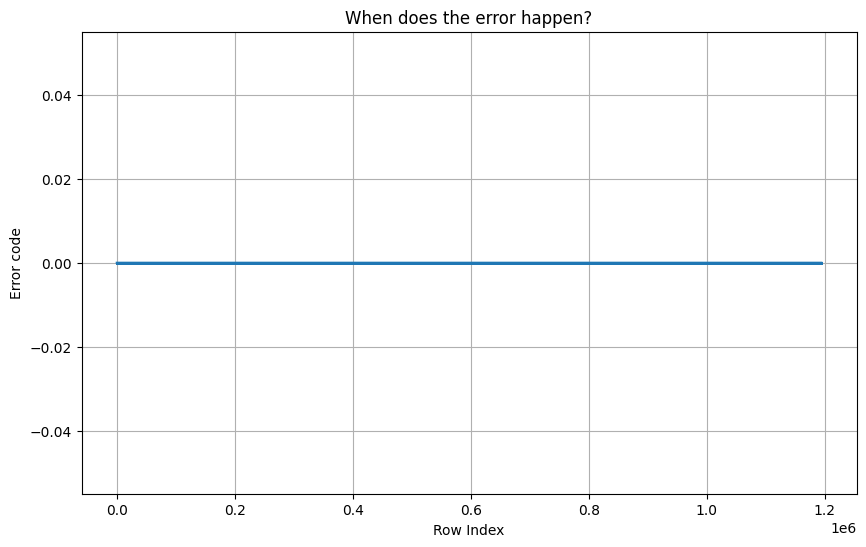

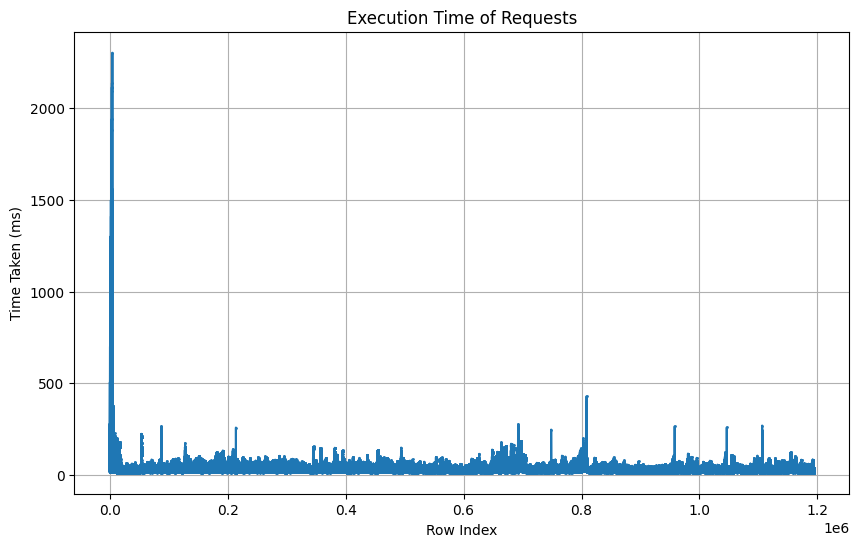

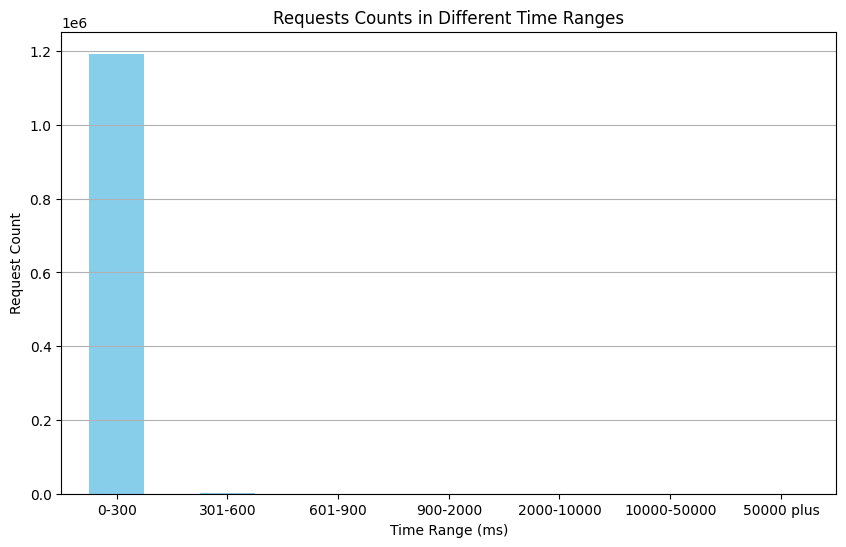

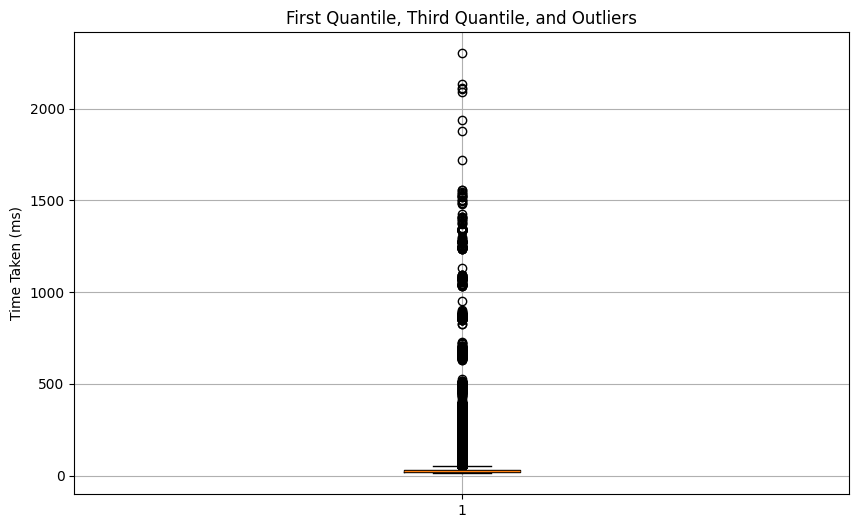

/tmp/ipykernel_201683/2483294046.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Actual num of thr started: 1500
Throughput: 10637.446866232269
Threads successfully requested: 1500
Threads success rate: 100.00%
Error Rate: 0.00%
Stats of the successful fetches:
Mean: 52.93932660436984
Median: 31.0
Standard Deviation: 69.13589668595


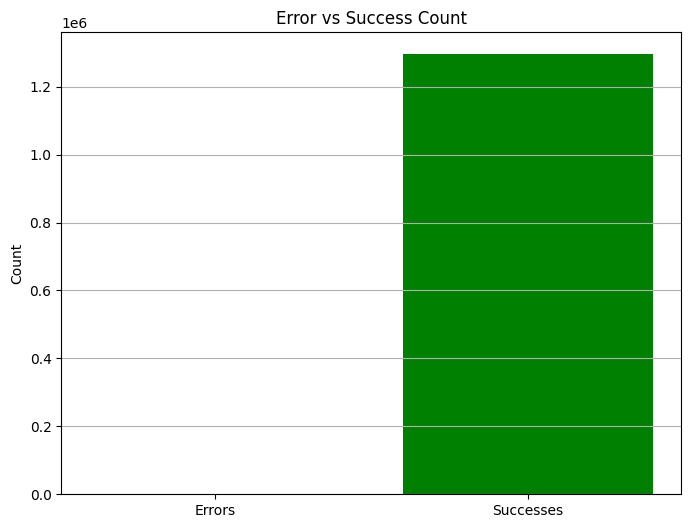

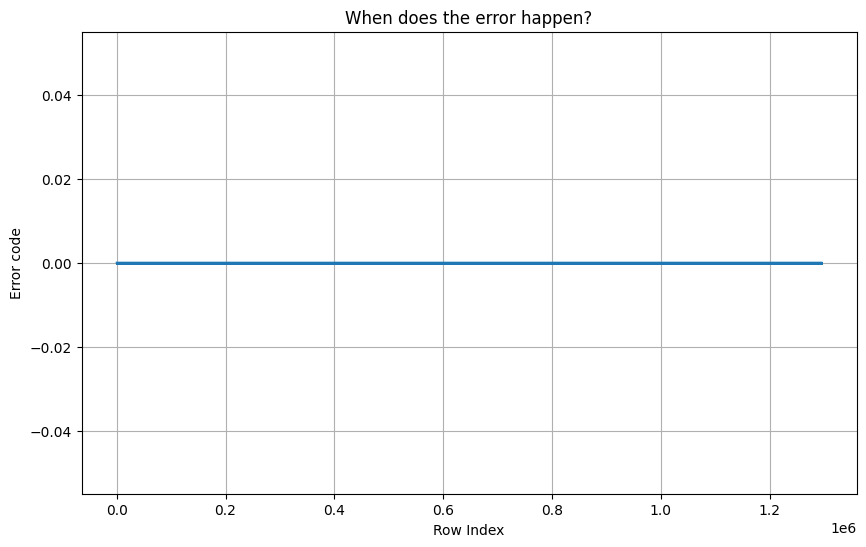

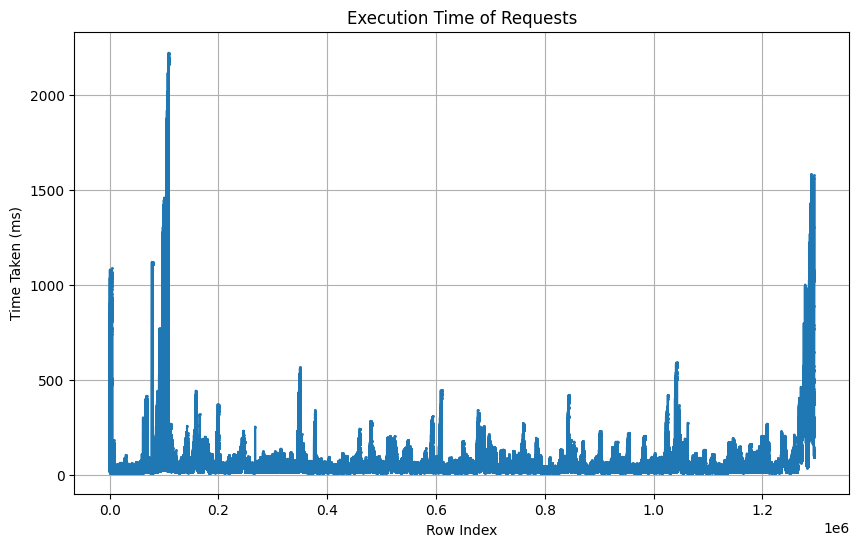

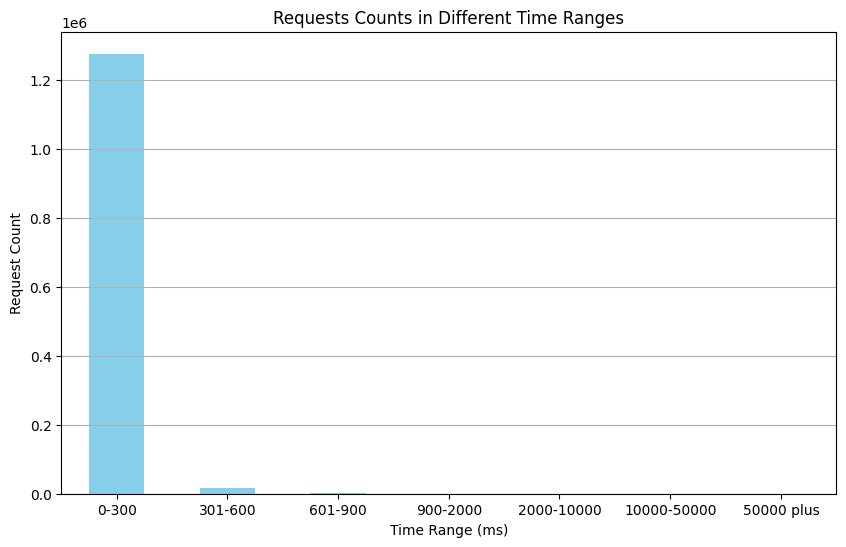

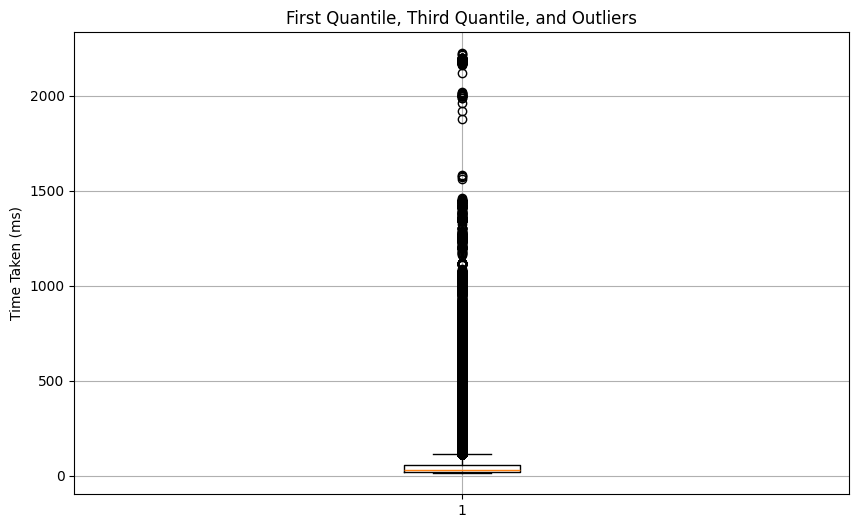

/tmp/ipykernel_201683/2483294046.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Actual num of thr started: 1200
Throughput: 10622.980382969923
Threads successfully requested: 1200
Threads success rate: 100.00%
Error Rate: 0.00%
Stats of the successful fetches:
Mean: 37.66116126673417
Median: 25.0
Standard Deviation: 39.0228653368281


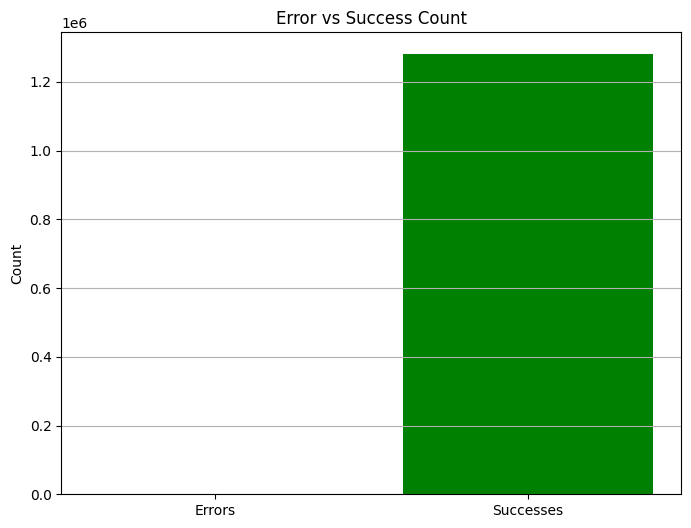

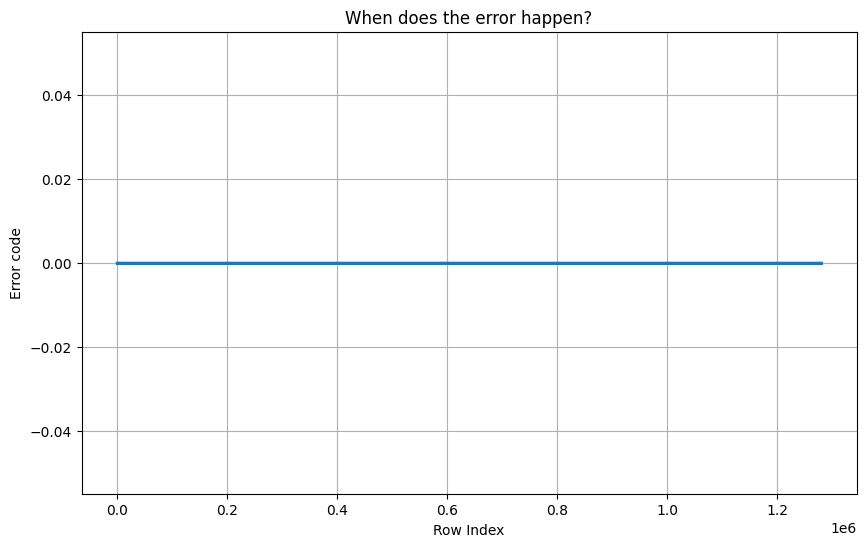

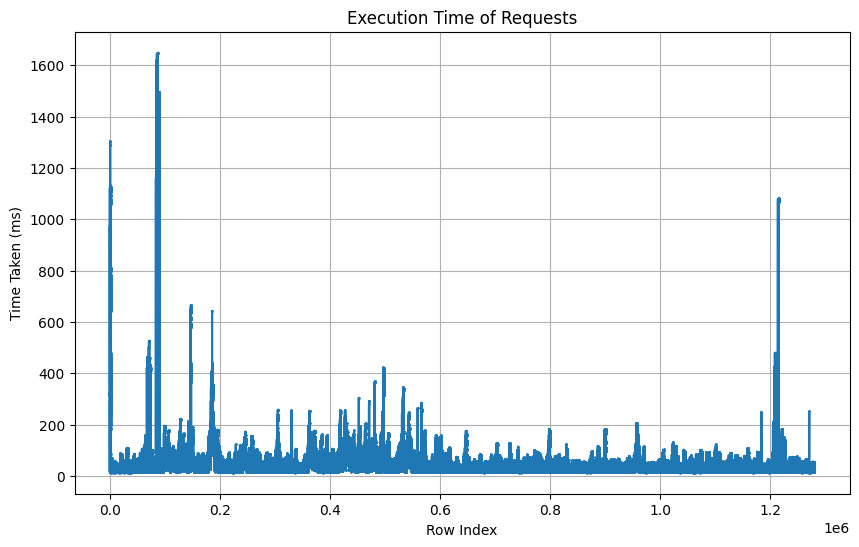

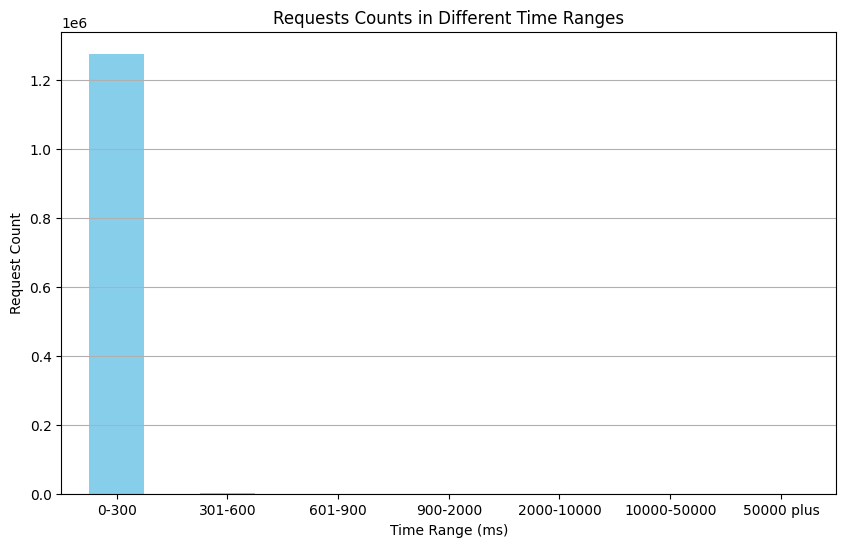

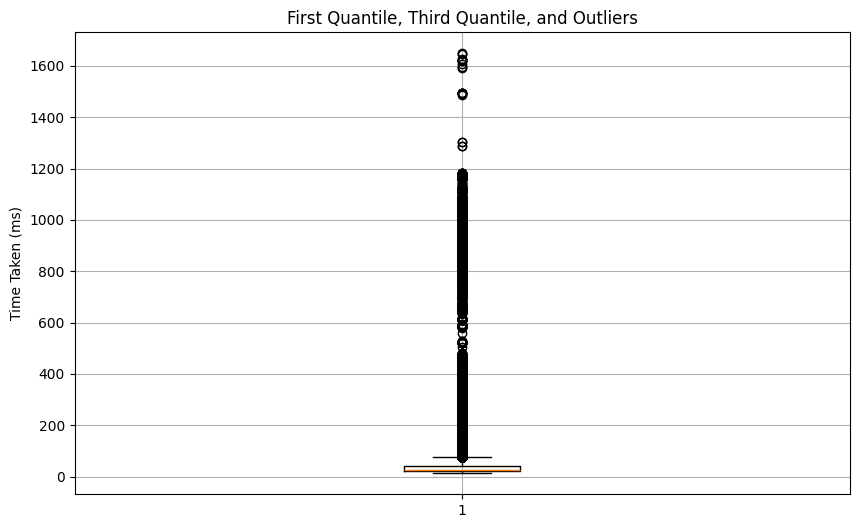

In [4]:
# Directory containing CSV files
folder_path = "output-swi"

# Regular expression pattern to match "{numThreads}thr" in the file name
pattern = r"(\d+)thr"

# Iterate over files in the directory
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        # Use regular expression to extract expected number of threads from file name
        match = re.search(pattern, file_name)
        if match:
            expected_number_of_threads = int(match.group(1))
        
            # Construct full file path
            file_path = os.path.join(folder_path, file_name)
            
            # Call analyze_csv function with file path and expected number of threads
            analyze_csv(file_path, expected_number_of_threads)


## Multi-region to swi

### Test the jar files

To see if they actually produce the right amount of threads

/tmp/ipykernel_224303/836848700.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Actual num of thr started: 1000
Throughput: 1932.2711556502322
Threads successfully requested: 1000
Threads success rate: 100.00%
Error Rate: 0.20%
Stats of the successful fetches:
Mean: 55.3645068973469
Median: 20.0
Standard Deviation: 150.0878628276494


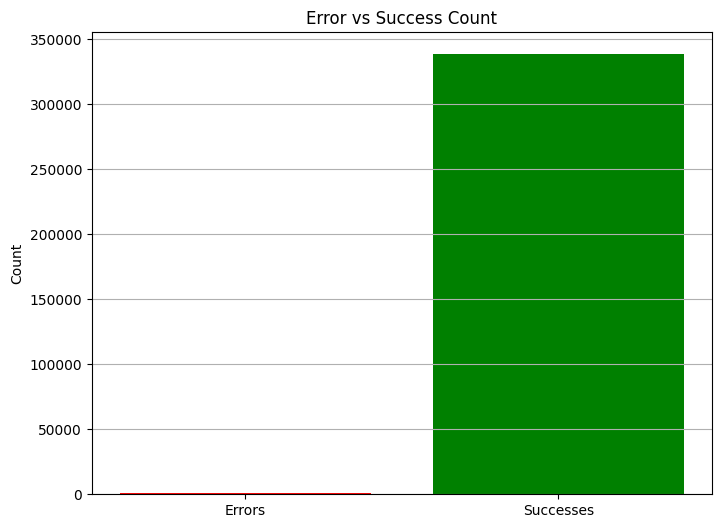

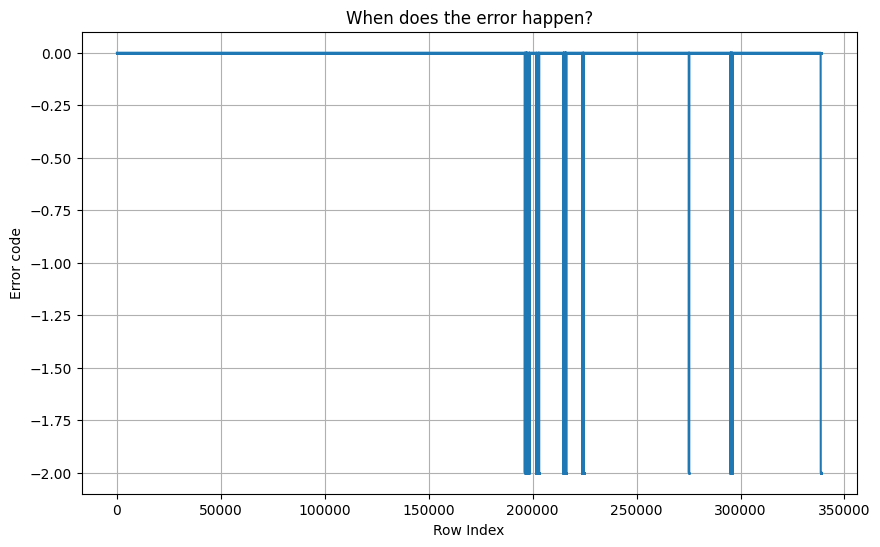

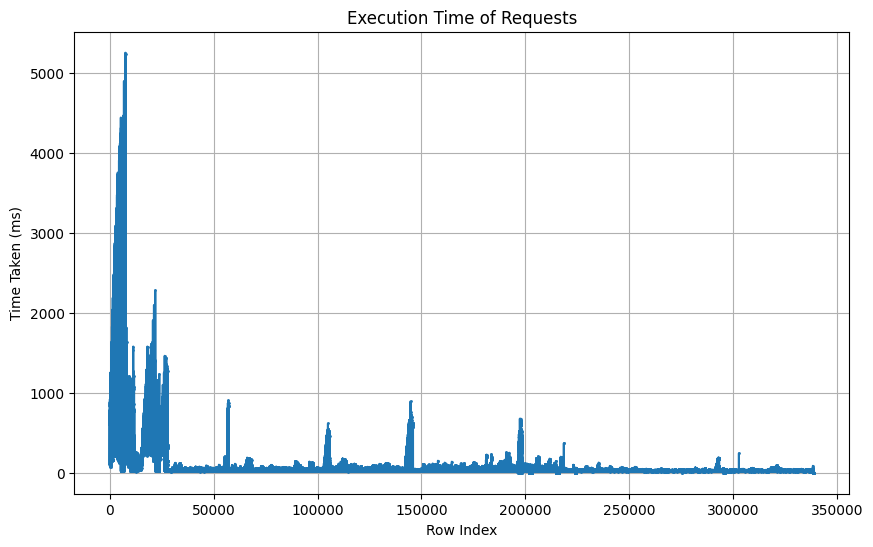

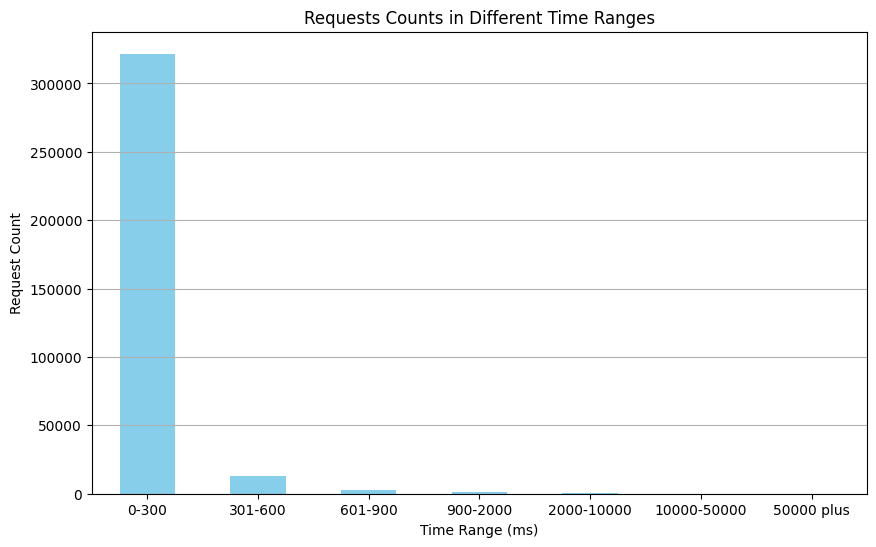

/tmp/ipykernel_224303/836848700.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Actual num of thr started: 250
Throughput: 3397.021001443788
Threads successfully requested: 250
Threads success rate: 100.00%
Error Rate: 0.00%
Stats of the successful fetches:
Mean: 30.72731325006123
Median: 19.0
Standard Deviation: 49.40441349204085


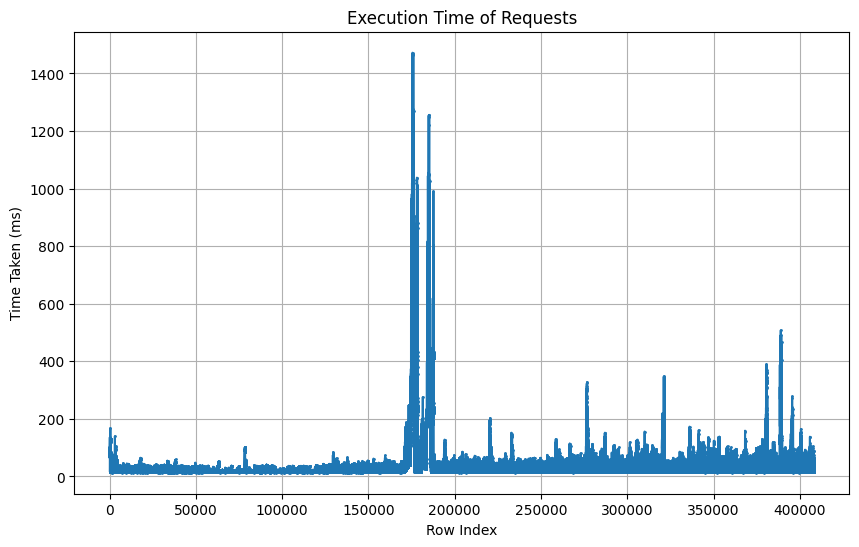

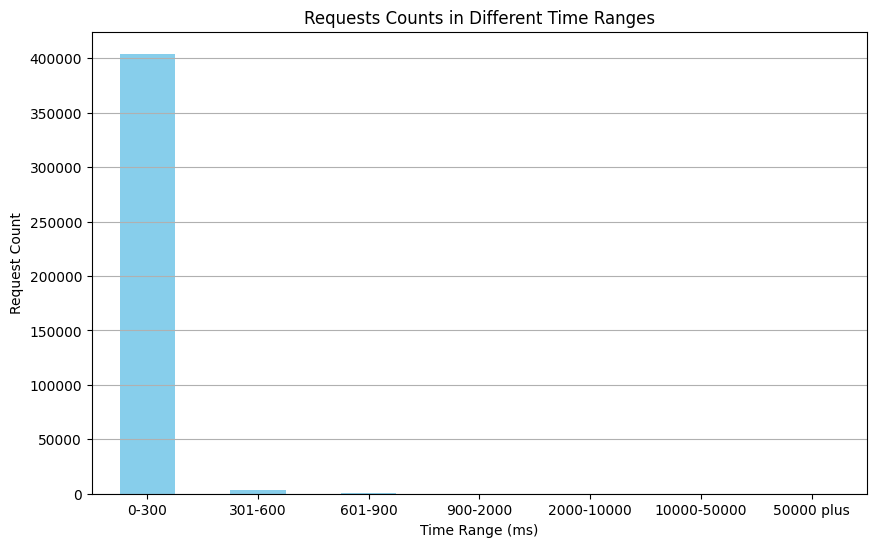

/tmp/ipykernel_224303/836848700.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Actual num of thr started: 500
Throughput: 1906.047141665854
Threads successfully requested: 500
Threads success rate: 100.00%
Error Rate: 0.00%
Stats of the successful fetches:
Mean: 42.946817915255274
Median: 21.0
Standard Deviation: 80.44978252119897


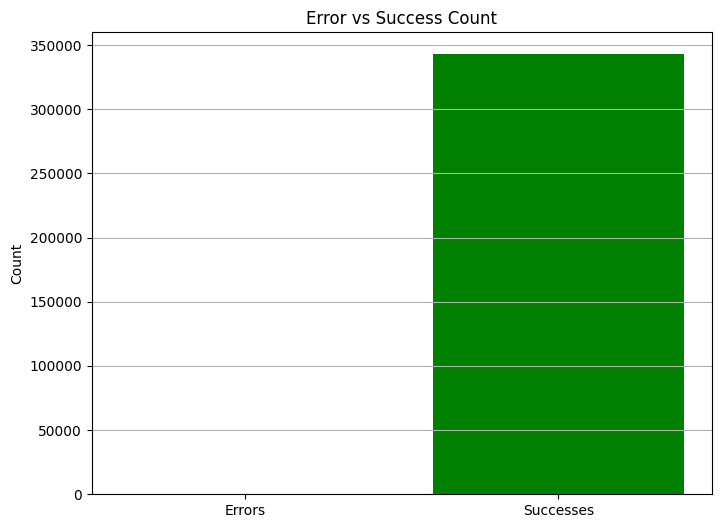

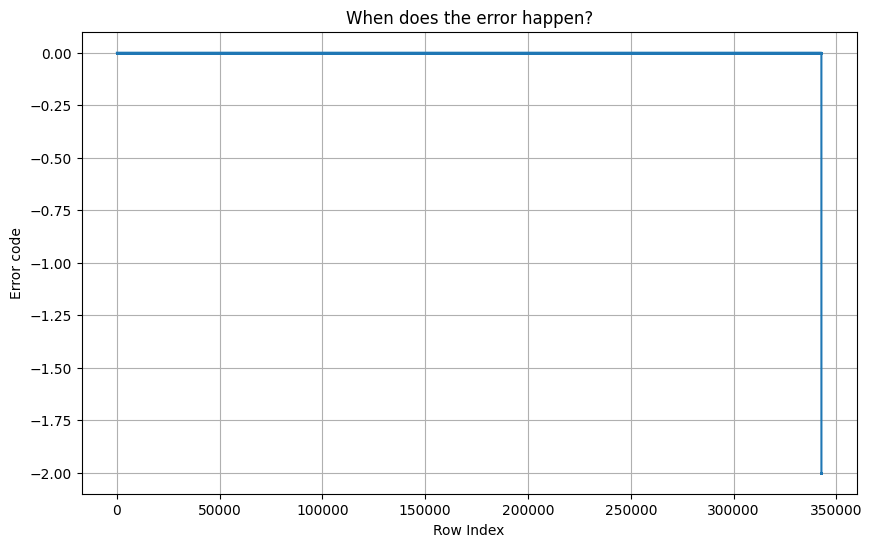

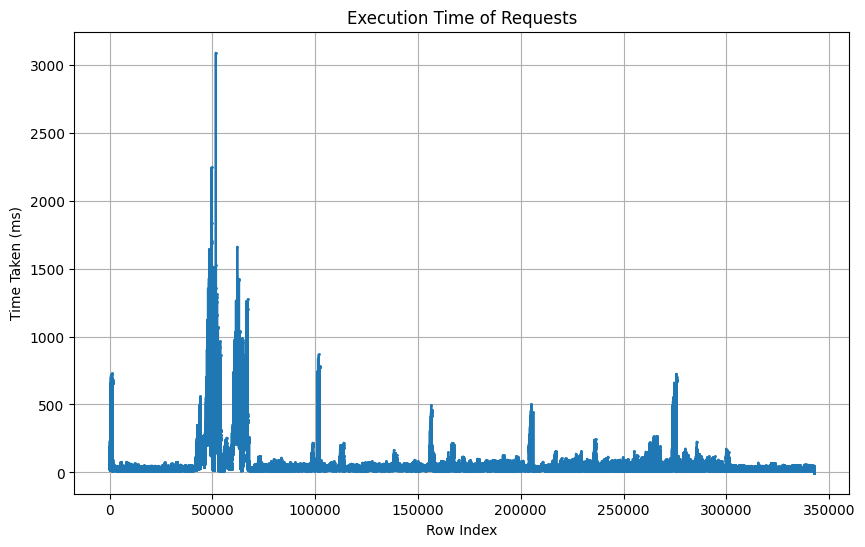

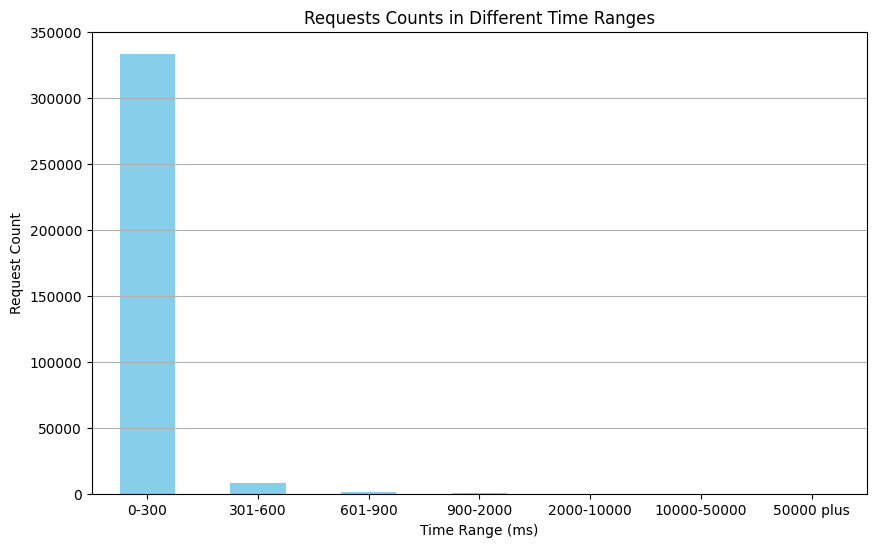

In [3]:
# Directory containing CSV files
folder_path = "multi-region-to-swi/output-rmi-to-swi"

# Regular expression pattern to match "{numThreads}thr" in the file name
pattern = r"(\d+)thr"

# Iterate over files in the directory
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        # Use regular expression to extract expected number of threads from file name
        match = re.search(pattern, file_name)
        if match:
            expected_number_of_threads = int(match.group(1))
        
            # Construct full file path
            file_path = os.path.join(folder_path, file_name)
            
            # Call analyze_csv function with file path and expected number of threads
            analyze_csv(file_path, expected_number_of_threads)

### Lets do it

In [ ]:
df_concat_250thr = concat_bra_local("multi-region-to-swi/output-from-bra/output-250thr-2min-timeout.csv", 
                                    "multi-region-to-swi/output-from-local/output-250thr-2min-timeout.csv",
                                    "multi-region-to-swi/processing/concat-bra-eu-250thr.csv")

df_bra = pd.read_csv("multi-region-to-swi/output-from-bra/output-250thr-2min-timeout.csv")
print(len(df_bra))
df_local = pd.read_csv("multi-region-to-swi/output-from-local/output-250thr-2min-timeout.csv")
print(len(df_local))
print(df_concat_250thr)

In [34]:
df_concat_500thr = concat_bra_local("multi-region-to-swi/output-from-bra/output-500thr-2min-timeout.csv", 
                                    "multi-region-to-swi/output-from-local/output-500thr-2min-timeout.csv",
                                    "multi-region-to-swi/processing/concat-bra-eu-500thr.csv")

/tmp/ipykernel_224303/2345047743.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/tmp/ipykernel_224303/2345047743.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [21]:
result_bra = analyze_csv_noplot("multi-region-to-swi/output-from-bra/output-250thr-2min-timeout.csv", 250, "bra-250thr")
result_local = analyze_csv_noplot("multi-region-to-swi/output-from-local/output-250thr-2min-timeout.csv", 250, "local-250thr")
result_concat = analyze_csv_noplot("multi-region-to-swi/processing/concat-bra-eu-250thr.csv", 500, "bra-local-250thr-each", with_regions=True)
result_bra_alone = analyze_csv_noplot("multi-region-to-swi/output-from-bra-alone/output-250thr-2min-timeout.csv", 250, "bra-250thr-alone")
result_local_alone = analyze_csv_noplot("multi-region-to-swi/output-from-local-alone/output-250thr-2min-timeout.csv", 250, "local-250thr-alone")

/tmp/ipykernel_224303/417539148.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)
/tmp/ipykernel_224303/417539148.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


In [37]:
result_bra_500 = analyze_csv_noplot("multi-region-to-swi/output-from-bra/output-500thr-2min-timeout.csv", 500, "bra-500thr")
result_local_500 = analyze_csv_noplot("multi-region-to-swi/output-from-local/output-500thr-2min-timeout.csv", 500, "local-500thr")
result_concat_500 = analyze_csv_noplot("multi-region-to-swi/processing/concat-bra-eu-500thr.csv", 1000, "bra-local-500thr-each", with_regions=True)
result_bra_alone_500 = analyze_csv_noplot("multi-region-to-swi/output-from-bra-alone/output-500thr-2min-timeout.csv", 500, "bra-500thr-alone")
result_local_alone_500 = analyze_csv_noplot("multi-region-to-swi/output-from-local-alone/output-500thr-2min-timeout.csv", 500, "local-500thr-alone")

/tmp/ipykernel_224303/417539148.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)
/tmp/ipykernel_224303/417539148.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)
/tmp/ipykernel_224303/417539148.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)
/tmp/ipykernel_224303/417539148.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)
/tmp/ipykernel_224303/417539148.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


In [23]:
print(result_bra)
print(result_local)
print(result_concat)
print(result_bra_alone)
print(result_local_alone)

                                      Value
Name                             bra-250thr
Actual num of thr started               250
Threads successfully requested          250
Threads success rate (%)              100.0
Error Rate (%)                          0.0
Throughput                      1241.810444
Mean                             199.720752
Median                                198.0
Standard Deviation                25.779814
                                       Value
Name                            local-250thr
Actual num of thr started                250
Threads successfully requested           250
Threads success rate (%)               100.0
Error Rate (%)                           0.0
Throughput                      11254.500521
Mean                               19.815593
Median                                  18.0
Standard Deviation                 13.052983
                                                Value
Name                            bra-local-250thr-each
Ac

In [38]:
print(result_bra_500)
print(result_local_500)
print(result_concat_500)
print(result_bra_alone_500)
print(result_local_alone_500)

                                      Value
Name                             bra-500thr
Actual num of thr started               500
Threads successfully requested          500
Threads success rate (%)              100.0
Error Rate (%)                          0.0
Throughput                      2411.994936
Mean                             202.229462
Median                                199.0
Standard Deviation                38.971148
                                       Value
Name                            local-500thr
Actual num of thr started                500
Threads successfully requested           500
Threads success rate (%)               100.0
Error Rate (%)                           0.0
Throughput                      13184.856292
Mean                               23.803756
Median                                  21.0
Standard Deviation                 10.532204
                                                Value
Name                            bra-local-500thr-each
Ac

In [33]:
all_results = [result_bra.T, result_local.T, result_concat.T, result_bra_alone.T, result_local_alone.T]
# Concatenate the DataFrames vertically
concatenated_df = pd.concat(all_results)

# Reset index to concatenate the DataFrames properly
concatenated_df.reset_index(drop=True, inplace=True)
print(concatenated_df)

concatenated_df.to_csv("multi-region-to-swi/processing/result-250thr-all.csv", index=False)

                    Name Actual num of thr started  \
0             bra-250thr                       250   
1           local-250thr                       250   
2  bra-local-250thr-each                       500   
3       bra-250thr-alone                       250   
4     local-250thr-alone                       250   

  Threads successfully requested Threads success rate (%) Error Rate (%)  \
0                            250                    100.0            0.0   
1                            250                    100.0            0.0   
2                            500                    100.0            0.0   
3                            250                    100.0            0.0   
4                            250                    100.0            0.0   

     Throughput        Mean Median Standard Deviation  
0   1241.810444  199.720752  198.0          25.779814  
1  11254.500521   19.815593   18.0          13.052983  
2  12475.045272   37.723993   19.0          55.863

In [40]:
all_results_500 = [result_bra_500.T, result_local_500.T, result_concat_500.T, result_bra_alone_500.T, result_local_alone_500.T]
# Concatenate the DataFrames vertically
concatenated_df = pd.concat(all_results_500)

# Reset index to concatenate the DataFrames properly
concatenated_df.reset_index(drop=True, inplace=True)
print(concatenated_df)

concatenated_df.to_csv("multi-region-to-swi/processing/result-500thr-all.csv", index=False)

                    Name Actual num of thr started  \
0             bra-500thr                       500   
1           local-500thr                       500   
2  bra-local-500thr-each                      1000   
3       bra-500thr-alone                       500   
4     local-500thr-alone                       500   

  Threads successfully requested Threads success rate (%) Error Rate (%)  \
0                            500                    100.0            0.0   
1                            500                    100.0            0.0   
2                           1000                    100.0            0.0   
3                            500                    100.0            0.0   
4                            500                    100.0            0.0   

     Throughput        Mean Median Standard Deviation  
0   2411.994936  202.229462  199.0          38.971148  
1  13184.856292   23.803756   21.0          10.532204  
2  15544.612014   51.489355   22.0            67.1

/tmp/ipykernel_224303/4064114159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={'Name': 'Name of specific test'}, inplace=True)
/tmp/ipykernel_224303/4064114159.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={'Mean': 'Mean Response Time (ms)'}, inplace=True)
/tmp/ipykernel_224303/4064114159.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={'T

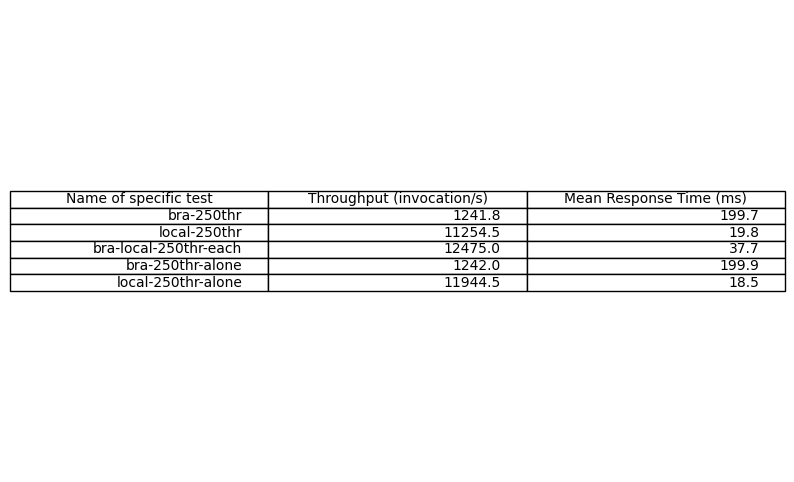

In [69]:
df = pd.read_csv('multi-region-to-swi/processing/result-250thr-all.csv')

df_selected = df[['Name', 'Throughput', 'Mean']]

# Rename the 'Mean' column to 'Mean Response Time'
df_selected.rename(columns={'Name': 'Name of specific test'}, inplace=True)
df_selected.rename(columns={'Mean': 'Mean Response Time (ms)'}, inplace=True)
df_selected.rename(columns={'Throughput': 'Throughput (invocation/s)'}, inplace=True)
df_selected = df_selected.round({'Throughput (invocation/s)': 1, 'Threads success rate (%)': 1, 'Error Rate (%)':1,  'Mean Response Time (ms)': 1})

# Plot the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_selected.values, colLabels=df_selected.columns, loc='center')

# Save the plot as an image
plt.savefig('multi-region-to-swi/processing/main-table.png', bbox_inches='tight')
plt.show()